In [1]:
import os
import random

import torch
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

from tqdm import tqdm   # show loops progress

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version from PyTorch: {torch.version.cuda}")

PyTorch version: 2.5.1
CUDA version from PyTorch: 12.1


In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 4070 Ti SUPER


**SEED**

In [4]:
SEED:int = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**LOAD TRAIN DATA**

In [5]:
# Dataset personalizado para DRIVE
class Dataset(Dataset):
    def __init__(self, image_dir, ground_truth, transform=None, transform_img=None):
        self.image_dir = image_dir
        self.ground_truth_dir = ground_truth
        self.image_filenames = os.listdir(image_dir)  
        self.mask_filenames = os.listdir(ground_truth)   
        self.transform = transform
        self.transform_img = transform_img

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        ground_truth_path = os.path.join(self.ground_truth_dir, self.mask_filenames[idx])
        
        image = Image.open(image_path).convert('RGB')
        ground_truth = Image.open(ground_truth_path).convert('L')  # gt to grayscale
        
        # image to tensor (needed to concatenate and more)
        image = transforms.ToTensor()(image)
        ground_truth = transforms.ToTensor()(ground_truth)
        
        if self.transform:        # exactly same transformations to image and gt
            # Concatenate along channel dimension.
            # Here, dim=0 is the channel dimension (not the batch dim) (here we have [C, H, W])
            image_and_gt = torch.cat([image, ground_truth], dim=0) 
            
            # Transform together
            transformed = self.transform(image_and_gt)

            # Slice the tensors out
            image = transformed[:3, :, :]    
            ground_truth = (transformed[3:, :, :] > 0.5).float()       # binarize !!!
        
        
        if self.transform_img:       # transformations only for images
            image = self.transform_img(image)
            

        return image, ground_truth, self.image_filenames[idx]

In [6]:
# Routes for training data
image_dir = './data/CHASE/training/images'
ground_truth_dir = './data/CHASE/training/2nd_manual'

''' # Just compute the mean and std
from torchvision import datasets
# calculate mean and std
dataset = Dataset(image_dir, ground_truth_dir, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

NORM_MEAN = 0.
NORM_STD = 0.
for images, _, _ in dataloader:
    NORM_MEAN += images.mean([0, 2, 3])  # channels means (R, G, B)
    NORM_STD += images.std([0, 2, 3])    # channels std

NORM_MEAN /= len(dataloader)
NORM_STD /= len(dataloader)

print(f"Mean: {NORM_MEAN}")
print(f"Std: {NORM_STD}")'''

' # Just compute the mean and std\nfrom torchvision import datasets\n# calculate mean and std\ndataset = Dataset(image_dir, ground_truth_dir, transform=transforms.ToTensor())\ndataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)\n\nNORM_MEAN = 0.\nNORM_STD = 0.\nfor images, _, _ in dataloader:\n    NORM_MEAN += images.mean([0, 2, 3])  # channels means (R, G, B)\n    NORM_STD += images.std([0, 2, 3])    # channels std\n\nNORM_MEAN /= len(dataloader)\nNORM_STD /= len(dataloader)\n\nprint(f"Mean: {NORM_MEAN}")\nprint(f"Std: {NORM_STD}")'

In [7]:
IMG_SIZE:int = 512
DATA_AUG_PROB:float = 0.85

from torchvision.transforms import v2

# transforms for images and its ground truth segmentations (same for both)
transform = v2.Compose([
    v2.RandomApply([
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        #v2.RandomZoomOut(fill=0, p=0.2), 
        v2.RandomAffine(degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.5, 1.5)),
        #v2.RandomResizedCrop(IMG_SIZE),
        #v2.ElasticTransform(alpha=15.0),
        #v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
        
    ], p=DATA_AUG_PROB),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    
    # transforms.Grayscale(num_output_channels=1),       # we want rgb    
    #transforms.ToTensor(),             # already tensors
    #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),   # no
    
])

# transform just for the image
transform_img = v2.Compose([
    v2.RandomApply([
        v2.ColorJitter(brightness=[0.6, 1.2], contrast=[0.3, 1.3], saturation=[0.5, 1.3], hue=0.015),
        v2.RandomAdjustSharpness(sharpness_factor=1.5),
        #v2.GaussianNoise(),

    ], p=DATA_AUG_PROB),
     
    #transforms.ToTensor(),             # already tensors
    #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),   # no
    
])


dataset = Dataset(image_dir, ground_truth_dir, transform=transform, transform_img=transform_img)

In [8]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)
for img, gt, _ in example_loader:
    print(img.shape)
    print(gt.shape)
    print("\n")
    break

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])




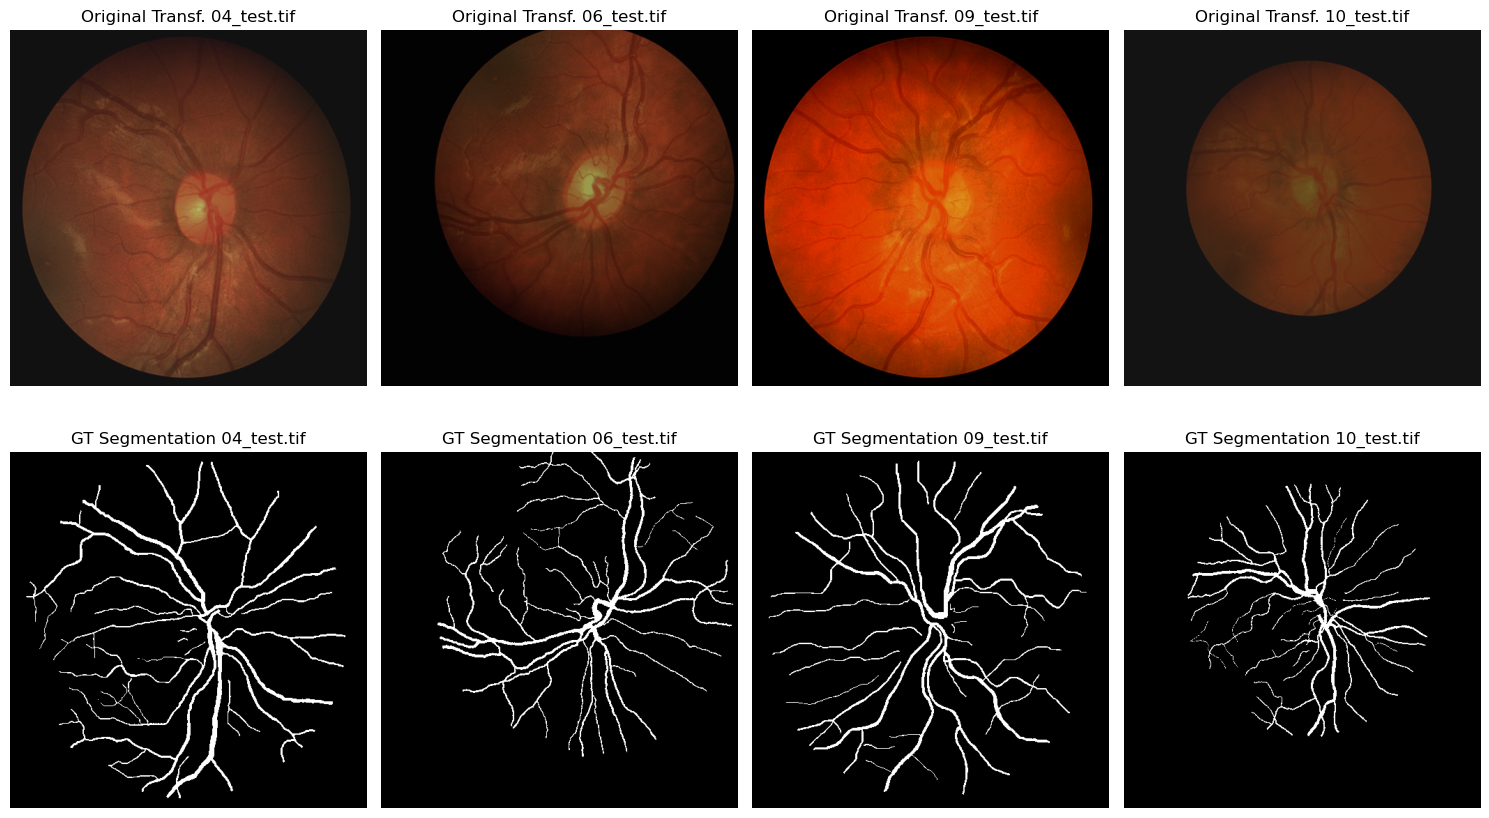

In [9]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

# Obtener algunas imágenes y máscaras del example_loader
data_iter = iter(example_loader)
images, ground_truth, img_name = next(data_iter)

# Convertir los tensores a formato numpy para visualizarlos
images = images.numpy().transpose(0, 2, 3, 1)  # [N, C, H, W] a [N, H, W, C]
ground_truth = ground_truth.numpy()  # [N, H, W] para las máscaras

# Eliminar la dimensión extra (1, H, W) de las máscaras
ground_truth = np.squeeze(ground_truth)  # Esto convierte la forma (1, H, W) a (H, W)

# Visualizar las imágenes en la fila superior y las máscaras en la fila inferior
fig, axes = plt.subplots(2, 4, figsize=(15, 9))  # 2 filas, 4 columnas (imágenes arriba y máscaras abajo)

for i in range(4):
    # Mostrar la imagen en la fila superior
    axes[0, i].imshow(images[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original Transf. {img_name[i]}')
    
    # Mostrar la máscara en la fila inferior
    axes[1, i].imshow(ground_truth[i], cmap='gray')  # show as grayscale
    axes[1, i].axis('off')
    axes[1, i].set_title(f'GT Segmentation {img_name[i]}')

plt.tight_layout()
plt.show()

**DATA SPLITTING**

In [10]:
VAL_PERCENT:float = 0.2            # Percentage of dataset intended for validation (rest is for training) 
BATCH_SIZE:int = 4

# Split into train / validation partitions
val_size = int(len(dataset) * VAL_PERCENT)     # number of samples for validation
train_size = len(dataset) - val_size           # number of samples for training
train_set, val_set = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

print('Training set has {} instances'.format(train_size))
print('Validation set has {} instances'.format(val_size))

Training set has 16 instances
Validation set has 4 instances


In [11]:
sample_image, sample_gt, _ = train_set[0]

NUM_CHANNELS_IN:int = sample_image.size(0)  
NUM_CHANNELS_OUT:int = sample_gt.size(0)

print(f"Number of channels in input: {NUM_CHANNELS_IN}")
print(f"Number of channels in output: {NUM_CHANNELS_OUT}")

Number of channels in input: 3
Number of channels in output: 1


**CREATE MODEL**

In [12]:
# from unet import UNet
# model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)

# from vig import ViGClassifier
# NUM_PATCHES:int = 196    #196
# PATCH_SIZE:int = int(IMG_SIZE//np.sqrt(NUM_PATCHES))
# print(f"{PATCH_SIZE=}")
# model = ViGClassifier(in_features = NUM_CHANNELS_IN * PATCH_SIZE * PATCH_SIZE,       # size of each input patch
#                    n_classes = NUM_CHANNELS_OUT,                                  # number of classes to predict
#                    num_patches = NUM_PATCHES,                                      
#                    patch_size = PATCH_SIZE,
#                    output_size = IMG_SIZE,
#                    out_feature = 192,                                             # features per node/patch (tiny: 192 |small: 320 |base: 640)
#                    num_ViGBlocks=12,                                              # number of Grapher module + FFN (tiny: 12 |small: 16 |base: 16)
#                    hidden_layer=1024,
#                    num_edges=7,                                                   # number of neigbours per node
#                    head_num=2,
#                   )


from vig_unet import ViGUNet
NUM_PATCHES:int = 14*14   #196         # ONLY PERFECT SQUARES
PATCH_SIZE:int = int(IMG_SIZE//np.sqrt(NUM_PATCHES))
model = ViGUNet(n_channels = NUM_CHANNELS_IN,
                n_classes = NUM_CHANNELS_OUT,                 # number of classes to predict
                in_features = NUM_CHANNELS_IN * PATCH_SIZE * PATCH_SIZE,       # size of each input patch
                out_feature = 192,                                             # features per node/patch (tiny: 192 |small: 320 |base: 640)
                num_patches = NUM_PATCHES,
                num_ViGBlocks = 12,                                              # number of Grapher module + FFN (tiny: 12 |small: 16 |base: 16)                                      
                num_edges = 9,   #9                                              # number of neigbours per node
                head_num = 1,    #1
                patch_size = PATCH_SIZE,
                output_size = IMG_SIZE,
                )


# cuda if available, cpu if not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device.type=}")
model.to(device)      # move to cuda if possible

#from torchsummary import summary
#summary(model, (NUM_CHANNELS_IN, IMG_SIZE, IMG_SIZE))

device.type='cuda'


ViGUNet(
  (inp): InputBlock(
    (conv): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): EncoderBlock(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128

**SOME HYPERPARAMETERS, SAVE PATH, CUDA**

In [13]:
EPOCHS:int = 1250

# save best model state path
SAVE_PATH = "./trained_models"
       

# LOSS FUNCTION -----------------------------------------------------
from utils.loss_functions import DiceLoss, DiceBCELoss, DiceBCELossWithTopology
#(need sigmoid at the end of network)

#loss_fn = torch.nn.BCELoss()        # binary cross-entropy loss 
#loss_fn = DiceLoss()
loss_fn = DiceBCELoss(bce_weight=0.5)      # weight of BCE
#loss_fn = DiceBCELossWithTopology(bce_weight=0.5, topology_weight=0.25, image_pixels=IMG_SIZE*IMG_SIZE)


# OPTIMIZER ---------------------------------------------------------
LEARNING_RATE:float = 0.001
MOMENTUM:float = 0.9
WEIGHT_DECAY:float = 1e-2

#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

optimizer = torch.optim.AdamW([
    {'params': model.parameters()},  # Parámetros del modelo
    {'params': loss_fn.parameters()}  # Parámetros de la pérdida
], lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

**TRAIN FUNCTION**

In [14]:
def training_loop(epochs, model, train_dataloader, val_dataloader, 
                  loss_fn, optimizer, save_path, patience=30):
    
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy':[], 'val_accuracy':[]}
    best_val_loss = float('inf')  # Initialize to infinity
    best_model_state = None
    datetime_start = datetime.now()
    
    early_stopping_counter = 0  # Counter for early stopping

    for epoch in range(1, epochs+1):
        model.train()
        running_train_loss = 0
        train_correct_pred = 0
        total_train_pred = 0
        
        for data in tqdm(train_dataloader):      # for each training batch
            
            img, ground_truth, _ = data
            img, ground_truth = img.to(device), ground_truth.to(device)     # move to cuda, if possible
            
            pred = model(img)
            # print(f"Pred shape: {pred.shape}, Ground truth shape: {ground_truth.shape}")   # debug
            # print(torch.max(pred))
            # print(torch.min(pred))
            # print(f"Pred device: {pred.device}, Ground truth device: {ground_truth.device}")
            # print(f"Pred type: {type(pred)}")
            # print(f"Pred content: {pred}")

            # print(f"Ground truth values: {ground_truth.unique()}")
            # print("\n")

            loss = loss_fn(pred, ground_truth)
            # print(loss)
            # print(loss.shape)
            running_train_loss += loss.item()
            train_correct_pred += ((pred > 0.5).float() == ground_truth).sum()      # add number of correct predictions
            total_train_pred += IMG_SIZE*IMG_SIZE*len(img)            # add number of predictions made (pixels per img * number of imgs)
            
            loss.backward()            # calculate gradients
            optimizer.step()           # update model parameters
            optimizer.zero_grad()      # reset gradients
        
        model.eval()
        with torch.no_grad():
            running_val_loss = 0
            val_correct_pred = 0
            total_val_pred = 0
            
            for data in tqdm(val_dataloader):      # for each validation batch
                
                img, ground_truth, _ = data
                img, ground_truth = img.to(device), ground_truth.to(device)       # move to cuda, if possible
                
                pred = model(img)
                loss = loss_fn(pred, ground_truth)
                
                running_val_loss += loss.item()
                val_correct_pred += ((pred > 0.5).float() == ground_truth).sum()         # add number of correct predictions
                total_val_pred += IMG_SIZE*IMG_SIZE*len(img)                     # add number of predictions made (pixels per img * number of imgs)


        train_loss = running_train_loss / len(train_dataloader.dataset)
        val_loss = running_val_loss / len(val_dataloader.dataset)
        train_acc = train_correct_pred / total_train_pred * 100       # % of average accuracy in training, in this epoch
        val_acc = val_correct_pred / total_val_pred * 100             # % of average accuracy in validation, in this epoch

        history['train_loss'].append(train_loss)         # add metrics in this epoch to the record
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss:.5f} | Validation loss: {val_loss:.5f} | Training accuracy: {train_acc:.2f}% | Validation accuracy: {val_acc:.2f}%')
        print(f"\n")
        
        # Save the model if the validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save the model state
            early_stopping_counter = 0   # Reset counter if validation loss improves
        else:
            early_stopping_counter += 1
            print(f"Validation loss did not improve. Early stopping counter: {early_stopping_counter}/{patience}")
        
        # Stop training if patience is exceeded
        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break
        
    # Save the best model state
    if best_model_state is not None:
        model_path = save_path + '/' + '{}_{}_{:.5f}'.format(datetime_start.strftime('%Y%m%d_%H%M%S'), type(model).__name__, best_val_loss)
        torch.save(best_model_state, model_path)    
        print(f'Best model saved at {model_path}')
    
    # save history (dictionary)
    history_path = save_path + '/' + '{}_{}_{:.5f}'.format(datetime_start.strftime('%Y%m%d_%H%M%S'), type(model).__name__, best_val_loss)+'_history'
    torch.save(history, history_path)
    print(f'\nHistory saved at {history_path}')
    
    model.eval()
    return history

In [15]:
# TRAIN THE CURRENT MODEL
start_time = datetime.now()

PATIENCE = 100

history = training_loop(EPOCHS, model, train_loader, val_loader, 
                        loss_fn, optimizer, SAVE_PATH, PATIENCE)

end_time = datetime.now()
print(f"\nTraining duration: {end_time - start_time}")

100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch: 1/1250 | Training loss: 0.30183 | Validation loss: 0.30466 | Training accuracy: 92.63% | Validation accuracy: 93.25%




100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Epoch: 2/1250 | Training loss: 0.30208 | Validation loss: 0.30572 | Training accuracy: 93.28% | Validation accuracy: 93.63%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 3/1250 | Training loss: 0.30258 | Validation loss: 0.29927 | Training accuracy: 93.79% | Validation accuracy: 94.34%




100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 4/1250 | Training loss: 0.29707 | Validation loss: 0.30953 | Training accuracy: 93.08% | Validation accuracy: 94.99%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 5/1250 | Training loss: 0.29771 | Validation loss: 0.30500 | Training accuracy: 94.10% | Validation accuracy: 93.85%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 6/1250 | Training loss: 0.29539 | Validation loss: 0.29164 | Training accuracy: 94.00% | Validation accuracy: 90.39%




100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 7/1250 | Training loss: 0.29204 | Validation loss: 0.28697 | Training accuracy: 93.66% | Validation accuracy: 93.11%




100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 8/1250 | Training loss: 0.28783 | Validation loss: 0.28787 | Training accuracy: 92.87% | Validation accuracy: 93.18%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 9/1250 | Training loss: 0.28642 | Validation loss: 0.28368 | Training accuracy: 93.30% | Validation accuracy: 92.35%




100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 10/1250 | Training loss: 0.28444 | Validation loss: 0.27583 | Training accuracy: 94.05% | Validation accuracy: 93.00%




100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 11/1250 | Training loss: 0.27911 | Validation loss: 0.27465 | Training accuracy: 93.39% | Validation accuracy: 94.14%




100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 12/1250 | Training loss: 0.27572 | Validation loss: 0.26551 | Training accuracy: 93.61% | Validation accuracy: 92.33%




100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch: 13/1250 | Training loss: 0.27156 | Validation loss: 0.27148 | Training accuracy: 93.52% | Validation accuracy: 93.47%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 14/1250 | Training loss: 0.26855 | Validation loss: 0.26972 | Training accuracy: 94.18% | Validation accuracy: 96.05%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 15/1250 | Training loss: 0.26058 | Validation loss: 0.26475 | Training accuracy: 93.37% | Validation accuracy: 93.07%




100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 16/1250 | Training loss: 0.25637 | Validation loss: 0.25853 | Training accuracy: 93.40% | Validation accuracy: 92.30%




100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 17/1250 | Training loss: 0.24460 | Validation loss: 0.23637 | Training accuracy: 92.93% | Validation accuracy: 95.47%




100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 18/1250 | Training loss: 0.25031 | Validation loss: 0.23919 | Training accuracy: 94.28% | Validation accuracy: 93.24%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 19/1250 | Training loss: 0.23565 | Validation loss: 0.23784 | Training accuracy: 92.96% | Validation accuracy: 94.33%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch: 20/1250 | Training loss: 0.22853 | Validation loss: 0.27992 | Training accuracy: 93.85% | Validation accuracy: 92.80%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 21/1250 | Training loss: 0.21829 | Validation loss: 0.23699 | Training accuracy: 93.34% | Validation accuracy: 92.72%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Epoch: 22/1250 | Training loss: 0.20933 | Validation loss: 0.24300 | Training accuracy: 93.03% | Validation accuracy: 93.41%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 23/1250 | Training loss: 0.21065 | Validation loss: 0.25450 | Training accuracy: 93.84% | Validation accuracy: 90.79%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


Epoch: 24/1250 | Training loss: 0.19909 | Validation loss: 0.22360 | Training accuracy: 93.68% | Validation accuracy: 94.07%




100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 25/1250 | Training loss: 0.19109 | Validation loss: 0.22584 | Training accuracy: 93.08% | Validation accuracy: 91.21%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 26/1250 | Training loss: 0.18920 | Validation loss: 0.19464 | Training accuracy: 93.86% | Validation accuracy: 93.11%




100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 27/1250 | Training loss: 0.18450 | Validation loss: 0.26211 | Training accuracy: 93.54% | Validation accuracy: 95.05%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch: 28/1250 | Training loss: 0.18268 | Validation loss: 0.22495 | Training accuracy: 93.43% | Validation accuracy: 93.94%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 29/1250 | Training loss: 0.18884 | Validation loss: 0.21488 | Training accuracy: 93.66% | Validation accuracy: 94.92%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Epoch: 30/1250 | Training loss: 0.18188 | Validation loss: 0.21710 | Training accuracy: 94.22% | Validation accuracy: 92.20%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Epoch: 31/1250 | Training loss: 0.17622 | Validation loss: 0.17208 | Training accuracy: 93.59% | Validation accuracy: 94.43%




100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 32/1250 | Training loss: 0.17362 | Validation loss: 0.21075 | Training accuracy: 92.90% | Validation accuracy: 90.92%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch: 33/1250 | Training loss: 0.17974 | Validation loss: 0.19175 | Training accuracy: 93.00% | Validation accuracy: 94.63%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 34/1250 | Training loss: 0.16991 | Validation loss: 0.21285 | Training accuracy: 94.13% | Validation accuracy: 92.92%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 35/1250 | Training loss: 0.16706 | Validation loss: 0.16660 | Training accuracy: 94.15% | Validation accuracy: 95.31%




100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 36/1250 | Training loss: 0.16389 | Validation loss: 0.17954 | Training accuracy: 94.33% | Validation accuracy: 92.29%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 37/1250 | Training loss: 0.16342 | Validation loss: 0.16780 | Training accuracy: 93.57% | Validation accuracy: 93.36%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Epoch: 38/1250 | Training loss: 0.16447 | Validation loss: 0.16836 | Training accuracy: 93.03% | Validation accuracy: 93.75%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Epoch: 39/1250 | Training loss: 0.15909 | Validation loss: 0.15668 | Training accuracy: 94.36% | Validation accuracy: 94.50%




100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 40/1250 | Training loss: 0.15980 | Validation loss: 0.15729 | Training accuracy: 94.21% | Validation accuracy: 92.79%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 41/1250 | Training loss: 0.16384 | Validation loss: 0.16244 | Training accuracy: 93.38% | Validation accuracy: 95.46%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Epoch: 42/1250 | Training loss: 0.16888 | Validation loss: 0.16524 | Training accuracy: 93.84% | Validation accuracy: 93.03%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Epoch: 43/1250 | Training loss: 0.16194 | Validation loss: 0.15566 | Training accuracy: 93.75% | Validation accuracy: 96.79%




100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch: 44/1250 | Training loss: 0.15740 | Validation loss: 0.16154 | Training accuracy: 93.13% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 45/1250 | Training loss: 0.15588 | Validation loss: 0.15724 | Training accuracy: 93.30% | Validation accuracy: 93.99%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 46/1250 | Training loss: 0.16227 | Validation loss: 0.15621 | Training accuracy: 91.86% | Validation accuracy: 94.76%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 47/1250 | Training loss: 0.15662 | Validation loss: 0.15359 | Training accuracy: 94.00% | Validation accuracy: 94.09%




100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Epoch: 48/1250 | Training loss: 0.15361 | Validation loss: 0.15544 | Training accuracy: 94.29% | Validation accuracy: 94.10%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch: 49/1250 | Training loss: 0.15608 | Validation loss: 0.15526 | Training accuracy: 93.37% | Validation accuracy: 94.10%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch: 50/1250 | Training loss: 0.15146 | Validation loss: 0.15717 | Training accuracy: 93.47% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch: 51/1250 | Training loss: 0.15305 | Validation loss: 0.14968 | Training accuracy: 93.95% | Validation accuracy: 96.12%




100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 52/1250 | Training loss: 0.15367 | Validation loss: 0.15830 | Training accuracy: 95.26% | Validation accuracy: 94.60%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 53/1250 | Training loss: 0.15397 | Validation loss: 0.15503 | Training accuracy: 96.22% | Validation accuracy: 95.79%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 54/1250 | Training loss: 0.15021 | Validation loss: 0.14801 | Training accuracy: 95.62% | Validation accuracy: 95.57%




100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch: 55/1250 | Training loss: 0.14907 | Validation loss: 0.16455 | Training accuracy: 95.73% | Validation accuracy: 95.06%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Epoch: 56/1250 | Training loss: 0.14924 | Validation loss: 0.15451 | Training accuracy: 95.66% | Validation accuracy: 95.87%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch: 57/1250 | Training loss: 0.14633 | Validation loss: 0.14773 | Training accuracy: 96.74% | Validation accuracy: 96.49%




100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 58/1250 | Training loss: 0.14842 | Validation loss: 0.15822 | Training accuracy: 96.36% | Validation accuracy: 96.80%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch: 59/1250 | Training loss: 0.14480 | Validation loss: 0.15363 | Training accuracy: 96.89% | Validation accuracy: 94.98%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 60/1250 | Training loss: 0.14994 | Validation loss: 0.15288 | Training accuracy: 95.50% | Validation accuracy: 96.20%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch: 61/1250 | Training loss: 0.14661 | Validation loss: 0.14681 | Training accuracy: 96.39% | Validation accuracy: 96.13%




100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 62/1250 | Training loss: 0.14351 | Validation loss: 0.15094 | Training accuracy: 96.97% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Epoch: 63/1250 | Training loss: 0.14856 | Validation loss: 0.14945 | Training accuracy: 96.09% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 64/1250 | Training loss: 0.15038 | Validation loss: 0.16579 | Training accuracy: 95.73% | Validation accuracy: 95.60%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 65/1250 | Training loss: 0.14991 | Validation loss: 0.16255 | Training accuracy: 95.37% | Validation accuracy: 94.74%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Epoch: 66/1250 | Training loss: 0.14995 | Validation loss: 0.15649 | Training accuracy: 95.68% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch: 67/1250 | Training loss: 0.14821 | Validation loss: 0.16302 | Training accuracy: 95.77% | Validation accuracy: 96.08%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch: 68/1250 | Training loss: 0.14549 | Validation loss: 0.16986 | Training accuracy: 95.91% | Validation accuracy: 94.90%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 69/1250 | Training loss: 0.14796 | Validation loss: 0.15495 | Training accuracy: 95.50% | Validation accuracy: 95.56%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch: 70/1250 | Training loss: 0.14714 | Validation loss: 0.14323 | Training accuracy: 95.48% | Validation accuracy: 96.50%




100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch: 71/1250 | Training loss: 0.14457 | Validation loss: 0.14857 | Training accuracy: 96.32% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 72/1250 | Training loss: 0.14697 | Validation loss: 0.16812 | Training accuracy: 95.88% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 73/1250 | Training loss: 0.14347 | Validation loss: 0.16245 | Training accuracy: 96.53% | Validation accuracy: 93.65%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


Epoch: 74/1250 | Training loss: 0.14806 | Validation loss: 0.14266 | Training accuracy: 95.98% | Validation accuracy: 96.27%




100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Epoch: 75/1250 | Training loss: 0.14587 | Validation loss: 0.14818 | Training accuracy: 95.56% | Validation accuracy: 95.63%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 76/1250 | Training loss: 0.14128 | Validation loss: 0.14477 | Training accuracy: 96.66% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 77/1250 | Training loss: 0.14418 | Validation loss: 0.14713 | Training accuracy: 96.10% | Validation accuracy: 95.73%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 78/1250 | Training loss: 0.14810 | Validation loss: 0.14627 | Training accuracy: 95.57% | Validation accuracy: 96.21%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 79/1250 | Training loss: 0.14478 | Validation loss: 0.18990 | Training accuracy: 95.85% | Validation accuracy: 95.80%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch: 80/1250 | Training loss: 0.14196 | Validation loss: 0.25200 | Training accuracy: 96.04% | Validation accuracy: 93.23%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 81/1250 | Training loss: 0.14153 | Validation loss: 0.14225 | Training accuracy: 95.98% | Validation accuracy: 97.88%




100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Epoch: 82/1250 | Training loss: 0.14376 | Validation loss: 0.15385 | Training accuracy: 95.51% | Validation accuracy: 95.91%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 83/1250 | Training loss: 0.13966 | Validation loss: 0.14899 | Training accuracy: 96.29% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch: 84/1250 | Training loss: 0.13901 | Validation loss: 0.14196 | Training accuracy: 96.13% | Validation accuracy: 95.51%




100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Epoch: 85/1250 | Training loss: 0.14097 | Validation loss: 0.13832 | Training accuracy: 96.20% | Validation accuracy: 97.16%




100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 86/1250 | Training loss: 0.13974 | Validation loss: 0.14021 | Training accuracy: 95.96% | Validation accuracy: 96.21%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 87/1250 | Training loss: 0.14007 | Validation loss: 0.14219 | Training accuracy: 95.64% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 88/1250 | Training loss: 0.13835 | Validation loss: 0.13935 | Training accuracy: 96.14% | Validation accuracy: 96.59%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Epoch: 89/1250 | Training loss: 0.14046 | Validation loss: 0.13703 | Training accuracy: 95.78% | Validation accuracy: 96.15%




100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 90/1250 | Training loss: 0.13753 | Validation loss: 0.13666 | Training accuracy: 95.93% | Validation accuracy: 96.07%




100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch: 91/1250 | Training loss: 0.13906 | Validation loss: 0.13889 | Training accuracy: 95.96% | Validation accuracy: 95.46%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch: 92/1250 | Training loss: 0.13505 | Validation loss: 0.13589 | Training accuracy: 96.36% | Validation accuracy: 96.87%




100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Epoch: 93/1250 | Training loss: 0.13615 | Validation loss: 0.13940 | Training accuracy: 96.04% | Validation accuracy: 96.05%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 94/1250 | Training loss: 0.13629 | Validation loss: 0.13445 | Training accuracy: 96.50% | Validation accuracy: 95.70%




100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 95/1250 | Training loss: 0.13540 | Validation loss: 0.14277 | Training accuracy: 96.56% | Validation accuracy: 96.09%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch: 96/1250 | Training loss: 0.13473 | Validation loss: 0.14498 | Training accuracy: 96.48% | Validation accuracy: 96.28%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 97/1250 | Training loss: 0.13775 | Validation loss: 0.13271 | Training accuracy: 95.75% | Validation accuracy: 96.97%




100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 98/1250 | Training loss: 0.13527 | Validation loss: 0.13452 | Training accuracy: 96.08% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch: 99/1250 | Training loss: 0.13363 | Validation loss: 0.13645 | Training accuracy: 96.63% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch: 100/1250 | Training loss: 0.13459 | Validation loss: 0.13166 | Training accuracy: 96.22% | Validation accuracy: 96.04%




100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 101/1250 | Training loss: 0.13347 | Validation loss: 0.13536 | Training accuracy: 96.38% | Validation accuracy: 95.64%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 102/1250 | Training loss: 0.13345 | Validation loss: 0.13659 | Training accuracy: 96.50% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch: 103/1250 | Training loss: 0.13568 | Validation loss: 0.13633 | Training accuracy: 96.61% | Validation accuracy: 96.26%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 104/1250 | Training loss: 0.13344 | Validation loss: 0.14181 | Training accuracy: 96.77% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 105/1250 | Training loss: 0.13214 | Validation loss: 0.13327 | Training accuracy: 96.45% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 106/1250 | Training loss: 0.13791 | Validation loss: 0.14471 | Training accuracy: 95.88% | Validation accuracy: 95.22%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 107/1250 | Training loss: 0.13699 | Validation loss: 0.14573 | Training accuracy: 95.72% | Validation accuracy: 96.63%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch: 108/1250 | Training loss: 0.13796 | Validation loss: 0.15354 | Training accuracy: 95.84% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 109/1250 | Training loss: 0.13824 | Validation loss: 0.14471 | Training accuracy: 95.86% | Validation accuracy: 95.62%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 110/1250 | Training loss: 0.13850 | Validation loss: 0.13733 | Training accuracy: 95.90% | Validation accuracy: 95.44%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 111/1250 | Training loss: 0.13574 | Validation loss: 0.13329 | Training accuracy: 96.35% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 112/1250 | Training loss: 0.13393 | Validation loss: 0.13396 | Training accuracy: 96.52% | Validation accuracy: 95.68%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 113/1250 | Training loss: 0.13214 | Validation loss: 0.13301 | Training accuracy: 96.61% | Validation accuracy: 95.62%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Epoch: 114/1250 | Training loss: 0.13481 | Validation loss: 0.13319 | Training accuracy: 95.50% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Epoch: 115/1250 | Training loss: 0.13292 | Validation loss: 0.12890 | Training accuracy: 95.76% | Validation accuracy: 97.59%




100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch: 116/1250 | Training loss: 0.13272 | Validation loss: 0.13006 | Training accuracy: 95.42% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 117/1250 | Training loss: 0.12889 | Validation loss: 0.13554 | Training accuracy: 96.68% | Validation accuracy: 96.06%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 118/1250 | Training loss: 0.13171 | Validation loss: 0.13165 | Training accuracy: 96.23% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 119/1250 | Training loss: 0.13234 | Validation loss: 0.12945 | Training accuracy: 96.01% | Validation accuracy: 96.59%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 120/1250 | Training loss: 0.13197 | Validation loss: 0.12736 | Training accuracy: 96.35% | Validation accuracy: 96.49%




100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 121/1250 | Training loss: 0.13255 | Validation loss: 0.13255 | Training accuracy: 96.08% | Validation accuracy: 96.31%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Epoch: 122/1250 | Training loss: 0.13069 | Validation loss: 0.14634 | Training accuracy: 96.77% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 123/1250 | Training loss: 0.13053 | Validation loss: 0.16949 | Training accuracy: 96.77% | Validation accuracy: 95.28%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


Epoch: 124/1250 | Training loss: 0.13428 | Validation loss: 0.13527 | Training accuracy: 95.77% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 125/1250 | Training loss: 0.12821 | Validation loss: 0.13885 | Training accuracy: 96.28% | Validation accuracy: 94.98%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Epoch: 126/1250 | Training loss: 0.12906 | Validation loss: 0.13052 | Training accuracy: 96.74% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 127/1250 | Training loss: 0.13011 | Validation loss: 0.12655 | Training accuracy: 96.55% | Validation accuracy: 96.24%




100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 128/1250 | Training loss: 0.13025 | Validation loss: 0.12724 | Training accuracy: 96.12% | Validation accuracy: 96.47%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 129/1250 | Training loss: 0.12682 | Validation loss: 0.13196 | Training accuracy: 96.23% | Validation accuracy: 94.55%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 130/1250 | Training loss: 0.12780 | Validation loss: 0.13070 | Training accuracy: 96.76% | Validation accuracy: 96.44%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 131/1250 | Training loss: 0.12685 | Validation loss: 0.13770 | Training accuracy: 96.44% | Validation accuracy: 96.14%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Epoch: 132/1250 | Training loss: 0.12778 | Validation loss: 0.13137 | Training accuracy: 95.96% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch: 133/1250 | Training loss: 0.12608 | Validation loss: 0.12613 | Training accuracy: 95.83% | Validation accuracy: 97.20%




100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch: 134/1250 | Training loss: 0.12626 | Validation loss: 0.12470 | Training accuracy: 96.05% | Validation accuracy: 97.38%




100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Epoch: 135/1250 | Training loss: 0.12659 | Validation loss: 0.12363 | Training accuracy: 96.22% | Validation accuracy: 96.53%




100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 136/1250 | Training loss: 0.12472 | Validation loss: 0.12194 | Training accuracy: 96.32% | Validation accuracy: 97.41%




100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch: 137/1250 | Training loss: 0.12545 | Validation loss: 0.12569 | Training accuracy: 96.78% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 138/1250 | Training loss: 0.12374 | Validation loss: 0.12098 | Training accuracy: 96.64% | Validation accuracy: 96.45%




100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Epoch: 139/1250 | Training loss: 0.12326 | Validation loss: 0.12440 | Training accuracy: 97.37% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 140/1250 | Training loss: 0.12377 | Validation loss: 0.12576 | Training accuracy: 97.11% | Validation accuracy: 96.24%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 141/1250 | Training loss: 0.12574 | Validation loss: 0.12132 | Training accuracy: 96.24% | Validation accuracy: 96.51%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 142/1250 | Training loss: 0.12707 | Validation loss: 0.12660 | Training accuracy: 95.97% | Validation accuracy: 95.71%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch: 143/1250 | Training loss: 0.12533 | Validation loss: 0.12324 | Training accuracy: 96.78% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 144/1250 | Training loss: 0.12283 | Validation loss: 0.12352 | Training accuracy: 96.83% | Validation accuracy: 96.46%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 145/1250 | Training loss: 0.12286 | Validation loss: 0.12718 | Training accuracy: 96.65% | Validation accuracy: 95.84%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 146/1250 | Training loss: 0.12434 | Validation loss: 0.14185 | Training accuracy: 96.02% | Validation accuracy: 94.72%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Epoch: 147/1250 | Training loss: 0.12384 | Validation loss: 0.15642 | Training accuracy: 95.84% | Validation accuracy: 95.41%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


Epoch: 148/1250 | Training loss: 0.12099 | Validation loss: 0.12378 | Training accuracy: 96.77% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


Epoch: 149/1250 | Training loss: 0.12331 | Validation loss: 0.13003 | Training accuracy: 96.86% | Validation accuracy: 95.70%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


Epoch: 150/1250 | Training loss: 0.12084 | Validation loss: 0.12190 | Training accuracy: 96.55% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 151/1250 | Training loss: 0.12115 | Validation loss: 0.11945 | Training accuracy: 96.74% | Validation accuracy: 96.41%




100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


Epoch: 152/1250 | Training loss: 0.12093 | Validation loss: 0.12150 | Training accuracy: 96.29% | Validation accuracy: 96.35%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 153/1250 | Training loss: 0.12028 | Validation loss: 0.12238 | Training accuracy: 97.06% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 154/1250 | Training loss: 0.12068 | Validation loss: 0.12363 | Training accuracy: 96.68% | Validation accuracy: 96.22%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch: 155/1250 | Training loss: 0.12047 | Validation loss: 0.12069 | Training accuracy: 96.62% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Epoch: 156/1250 | Training loss: 0.12031 | Validation loss: 0.12095 | Training accuracy: 96.51% | Validation accuracy: 95.98%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 157/1250 | Training loss: 0.12174 | Validation loss: 0.11724 | Training accuracy: 96.06% | Validation accuracy: 97.11%




100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch: 158/1250 | Training loss: 0.11963 | Validation loss: 0.14513 | Training accuracy: 96.54% | Validation accuracy: 96.03%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Epoch: 159/1250 | Training loss: 0.11956 | Validation loss: 0.11528 | Training accuracy: 96.61% | Validation accuracy: 97.49%




100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 160/1250 | Training loss: 0.11930 | Validation loss: 0.11569 | Training accuracy: 96.69% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Epoch: 161/1250 | Training loss: 0.11786 | Validation loss: 0.11561 | Training accuracy: 96.98% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch: 162/1250 | Training loss: 0.11916 | Validation loss: 0.12225 | Training accuracy: 97.21% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Epoch: 163/1250 | Training loss: 0.11999 | Validation loss: 0.12176 | Training accuracy: 96.87% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 164/1250 | Training loss: 0.12144 | Validation loss: 0.12073 | Training accuracy: 96.12% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 165/1250 | Training loss: 0.11964 | Validation loss: 0.12289 | Training accuracy: 96.04% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Epoch: 166/1250 | Training loss: 0.11883 | Validation loss: 0.12329 | Training accuracy: 96.43% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch: 167/1250 | Training loss: 0.11875 | Validation loss: 0.11948 | Training accuracy: 96.72% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Epoch: 168/1250 | Training loss: 0.11781 | Validation loss: 0.11708 | Training accuracy: 97.22% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 169/1250 | Training loss: 0.11851 | Validation loss: 0.11733 | Training accuracy: 96.30% | Validation accuracy: 96.10%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Epoch: 170/1250 | Training loss: 0.11685 | Validation loss: 0.11450 | Training accuracy: 96.58% | Validation accuracy: 97.20%




100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 171/1250 | Training loss: 0.11736 | Validation loss: 0.11432 | Training accuracy: 96.59% | Validation accuracy: 97.33%




100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch: 172/1250 | Training loss: 0.11491 | Validation loss: 0.11743 | Training accuracy: 97.19% | Validation accuracy: 96.55%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 173/1250 | Training loss: 0.11565 | Validation loss: 0.11670 | Training accuracy: 97.00% | Validation accuracy: 96.34%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 174/1250 | Training loss: 0.11706 | Validation loss: 0.11504 | Training accuracy: 96.39% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 175/1250 | Training loss: 0.11666 | Validation loss: 0.11395 | Training accuracy: 96.06% | Validation accuracy: 96.41%




100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 176/1250 | Training loss: 0.11747 | Validation loss: 0.11252 | Training accuracy: 96.64% | Validation accuracy: 97.41%




100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Epoch: 177/1250 | Training loss: 0.11498 | Validation loss: 0.11322 | Training accuracy: 97.07% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 178/1250 | Training loss: 0.12034 | Validation loss: 0.20655 | Training accuracy: 95.93% | Validation accuracy: 79.18%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch: 179/1250 | Training loss: 0.11630 | Validation loss: 0.14890 | Training accuracy: 96.96% | Validation accuracy: 93.86%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch: 180/1250 | Training loss: 0.11723 | Validation loss: 0.12641 | Training accuracy: 96.53% | Validation accuracy: 96.22%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 181/1250 | Training loss: 0.11977 | Validation loss: 0.12001 | Training accuracy: 95.92% | Validation accuracy: 95.42%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Epoch: 182/1250 | Training loss: 0.11674 | Validation loss: 0.11986 | Training accuracy: 96.69% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Epoch: 183/1250 | Training loss: 0.11686 | Validation loss: 0.11895 | Training accuracy: 96.85% | Validation accuracy: 97.10%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 184/1250 | Training loss: 0.11767 | Validation loss: 0.11828 | Training accuracy: 96.21% | Validation accuracy: 95.40%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Epoch: 185/1250 | Training loss: 0.11636 | Validation loss: 0.12315 | Training accuracy: 96.17% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 186/1250 | Training loss: 0.11566 | Validation loss: 0.11877 | Training accuracy: 96.70% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 187/1250 | Training loss: 0.11668 | Validation loss: 0.11574 | Training accuracy: 96.94% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch: 188/1250 | Training loss: 0.11541 | Validation loss: 0.11830 | Training accuracy: 96.63% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Epoch: 189/1250 | Training loss: 0.11599 | Validation loss: 0.11659 | Training accuracy: 96.79% | Validation accuracy: 98.01%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 190/1250 | Training loss: 0.11725 | Validation loss: 0.12595 | Training accuracy: 96.37% | Validation accuracy: 96.03%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 191/1250 | Training loss: 0.11464 | Validation loss: 0.11156 | Training accuracy: 96.44% | Validation accuracy: 97.01%




100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Epoch: 192/1250 | Training loss: 0.11369 | Validation loss: 0.11513 | Training accuracy: 96.68% | Validation accuracy: 96.28%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch: 193/1250 | Training loss: 0.11557 | Validation loss: 0.12323 | Training accuracy: 96.46% | Validation accuracy: 96.14%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Epoch: 194/1250 | Training loss: 0.11299 | Validation loss: 0.11656 | Training accuracy: 96.47% | Validation accuracy: 96.59%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 195/1250 | Training loss: 0.11500 | Validation loss: 0.12261 | Training accuracy: 96.51% | Validation accuracy: 95.85%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch: 196/1250 | Training loss: 0.11183 | Validation loss: 0.11135 | Training accuracy: 97.41% | Validation accuracy: 97.04%




100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 197/1250 | Training loss: 0.11211 | Validation loss: 0.12107 | Training accuracy: 96.91% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 198/1250 | Training loss: 0.11262 | Validation loss: 0.11088 | Training accuracy: 96.76% | Validation accuracy: 98.22%




100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 199/1250 | Training loss: 0.11242 | Validation loss: 0.10969 | Training accuracy: 96.44% | Validation accuracy: 96.82%




100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


Epoch: 200/1250 | Training loss: 0.11226 | Validation loss: 0.11109 | Training accuracy: 97.36% | Validation accuracy: 96.11%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch: 201/1250 | Training loss: 0.11304 | Validation loss: 0.10997 | Training accuracy: 96.63% | Validation accuracy: 96.63%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Epoch: 202/1250 | Training loss: 0.11033 | Validation loss: 0.10972 | Training accuracy: 96.71% | Validation accuracy: 96.64%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 203/1250 | Training loss: 0.11203 | Validation loss: 0.11436 | Training accuracy: 96.67% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


Epoch: 204/1250 | Training loss: 0.11040 | Validation loss: 0.10775 | Training accuracy: 96.82% | Validation accuracy: 96.87%




100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 205/1250 | Training loss: 0.11103 | Validation loss: 0.11068 | Training accuracy: 96.57% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Epoch: 206/1250 | Training loss: 0.11106 | Validation loss: 0.10598 | Training accuracy: 96.74% | Validation accuracy: 97.34%




100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Epoch: 207/1250 | Training loss: 0.11066 | Validation loss: 0.10687 | Training accuracy: 96.66% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Epoch: 208/1250 | Training loss: 0.11102 | Validation loss: 0.10928 | Training accuracy: 96.72% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 209/1250 | Training loss: 0.10954 | Validation loss: 0.10919 | Training accuracy: 97.25% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 210/1250 | Training loss: 0.10930 | Validation loss: 0.11566 | Training accuracy: 96.99% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch: 211/1250 | Training loss: 0.10892 | Validation loss: 0.10653 | Training accuracy: 97.02% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Epoch: 212/1250 | Training loss: 0.11058 | Validation loss: 0.10844 | Training accuracy: 96.41% | Validation accuracy: 96.27%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Epoch: 213/1250 | Training loss: 0.10883 | Validation loss: 0.11048 | Training accuracy: 96.82% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 214/1250 | Training loss: 0.11015 | Validation loss: 0.11518 | Training accuracy: 97.18% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 215/1250 | Training loss: 0.10920 | Validation loss: 0.11011 | Training accuracy: 96.93% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 216/1250 | Training loss: 0.11172 | Validation loss: 0.11035 | Training accuracy: 96.63% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 217/1250 | Training loss: 0.10822 | Validation loss: 0.12183 | Training accuracy: 96.83% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 218/1250 | Training loss: 0.10820 | Validation loss: 0.10965 | Training accuracy: 97.07% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 219/1250 | Training loss: 0.10918 | Validation loss: 0.10947 | Training accuracy: 96.62% | Validation accuracy: 98.05%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 220/1250 | Training loss: 0.10779 | Validation loss: 0.10936 | Training accuracy: 96.83% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Epoch: 221/1250 | Training loss: 0.10899 | Validation loss: 0.10741 | Training accuracy: 96.69% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 222/1250 | Training loss: 0.10803 | Validation loss: 0.10830 | Training accuracy: 96.83% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 223/1250 | Training loss: 0.10775 | Validation loss: 0.10451 | Training accuracy: 97.12% | Validation accuracy: 96.91%




100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Epoch: 224/1250 | Training loss: 0.10899 | Validation loss: 0.10496 | Training accuracy: 96.42% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch: 225/1250 | Training loss: 0.10776 | Validation loss: 0.10649 | Training accuracy: 96.72% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 226/1250 | Training loss: 0.10822 | Validation loss: 0.10394 | Training accuracy: 96.67% | Validation accuracy: 96.85%




100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Epoch: 227/1250 | Training loss: 0.10682 | Validation loss: 0.10657 | Training accuracy: 97.05% | Validation accuracy: 98.17%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 228/1250 | Training loss: 0.10614 | Validation loss: 0.10474 | Training accuracy: 97.18% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Epoch: 229/1250 | Training loss: 0.10635 | Validation loss: 0.10967 | Training accuracy: 96.99% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Epoch: 230/1250 | Training loss: 0.10630 | Validation loss: 0.10622 | Training accuracy: 96.82% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 231/1250 | Training loss: 0.10739 | Validation loss: 0.10452 | Training accuracy: 97.14% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 232/1250 | Training loss: 0.10501 | Validation loss: 0.10305 | Training accuracy: 97.10% | Validation accuracy: 97.81%




100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 233/1250 | Training loss: 0.10646 | Validation loss: 0.10614 | Training accuracy: 96.63% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 234/1250 | Training loss: 0.10632 | Validation loss: 0.10941 | Training accuracy: 96.89% | Validation accuracy: 98.41%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 235/1250 | Training loss: 0.10587 | Validation loss: 0.10772 | Training accuracy: 97.18% | Validation accuracy: 96.24%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 236/1250 | Training loss: 0.10624 | Validation loss: 0.10383 | Training accuracy: 96.83% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch: 237/1250 | Training loss: 0.10779 | Validation loss: 0.10232 | Training accuracy: 96.56% | Validation accuracy: 97.08%




100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Epoch: 238/1250 | Training loss: 0.10417 | Validation loss: 0.10357 | Training accuracy: 97.27% | Validation accuracy: 96.49%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch: 239/1250 | Training loss: 0.10615 | Validation loss: 0.10752 | Training accuracy: 96.56% | Validation accuracy: 96.25%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 240/1250 | Training loss: 0.10588 | Validation loss: 0.10274 | Training accuracy: 96.59% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 241/1250 | Training loss: 0.10620 | Validation loss: 0.10654 | Training accuracy: 96.66% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 242/1250 | Training loss: 0.10542 | Validation loss: 0.10665 | Training accuracy: 96.83% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch: 243/1250 | Training loss: 0.10675 | Validation loss: 0.10922 | Training accuracy: 96.30% | Validation accuracy: 96.75%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Epoch: 244/1250 | Training loss: 0.10598 | Validation loss: 0.10544 | Training accuracy: 96.51% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 245/1250 | Training loss: 0.10652 | Validation loss: 0.10261 | Training accuracy: 97.23% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 246/1250 | Training loss: 0.10613 | Validation loss: 0.10726 | Training accuracy: 96.62% | Validation accuracy: 96.31%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 247/1250 | Training loss: 0.10769 | Validation loss: 0.10911 | Training accuracy: 96.17% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 248/1250 | Training loss: 0.10654 | Validation loss: 0.10683 | Training accuracy: 96.92% | Validation accuracy: 96.17%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 249/1250 | Training loss: 0.10625 | Validation loss: 0.10485 | Training accuracy: 97.10% | Validation accuracy: 95.96%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Epoch: 250/1250 | Training loss: 0.10692 | Validation loss: 0.10461 | Training accuracy: 96.79% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 251/1250 | Training loss: 0.10636 | Validation loss: 0.10291 | Training accuracy: 96.61% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch: 252/1250 | Training loss: 0.10384 | Validation loss: 0.10284 | Training accuracy: 97.38% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 253/1250 | Training loss: 0.10377 | Validation loss: 0.10261 | Training accuracy: 97.10% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


Epoch: 254/1250 | Training loss: 0.10445 | Validation loss: 0.10158 | Training accuracy: 97.12% | Validation accuracy: 97.13%




100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch: 255/1250 | Training loss: 0.11590 | Validation loss: 0.10688 | Training accuracy: 95.82% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 256/1250 | Training loss: 0.10721 | Validation loss: 0.14010 | Training accuracy: 97.00% | Validation accuracy: 92.77%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch: 257/1250 | Training loss: 0.10641 | Validation loss: 0.11643 | Training accuracy: 96.99% | Validation accuracy: 95.47%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 258/1250 | Training loss: 0.10726 | Validation loss: 0.10771 | Training accuracy: 96.34% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 259/1250 | Training loss: 0.10575 | Validation loss: 0.11125 | Training accuracy: 96.97% | Validation accuracy: 95.82%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch: 260/1250 | Training loss: 0.11377 | Validation loss: 0.11729 | Training accuracy: 96.29% | Validation accuracy: 95.48%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 261/1250 | Training loss: 0.10682 | Validation loss: 0.11369 | Training accuracy: 97.23% | Validation accuracy: 96.65%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 262/1250 | Training loss: 0.10490 | Validation loss: 0.11449 | Training accuracy: 97.14% | Validation accuracy: 96.59%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch: 263/1250 | Training loss: 0.10634 | Validation loss: 0.11333 | Training accuracy: 96.58% | Validation accuracy: 95.30%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 264/1250 | Training loss: 0.10396 | Validation loss: 0.10868 | Training accuracy: 96.88% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Epoch: 265/1250 | Training loss: 0.10577 | Validation loss: 0.11040 | Training accuracy: 96.71% | Validation accuracy: 95.44%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


Epoch: 266/1250 | Training loss: 0.10629 | Validation loss: 0.10232 | Training accuracy: 96.60% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Epoch: 267/1250 | Training loss: 0.10525 | Validation loss: 0.09844 | Training accuracy: 96.67% | Validation accuracy: 97.65%




100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 268/1250 | Training loss: 0.10411 | Validation loss: 0.11606 | Training accuracy: 97.07% | Validation accuracy: 95.87%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 269/1250 | Training loss: 0.10286 | Validation loss: 0.10352 | Training accuracy: 96.69% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Epoch: 270/1250 | Training loss: 0.10351 | Validation loss: 0.10161 | Training accuracy: 96.66% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 271/1250 | Training loss: 0.10321 | Validation loss: 0.10779 | Training accuracy: 97.14% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 272/1250 | Training loss: 0.10108 | Validation loss: 0.10418 | Training accuracy: 97.15% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Epoch: 273/1250 | Training loss: 0.10148 | Validation loss: 0.09966 | Training accuracy: 97.30% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 274/1250 | Training loss: 0.10177 | Validation loss: 0.10808 | Training accuracy: 96.80% | Validation accuracy: 95.79%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch: 275/1250 | Training loss: 0.10203 | Validation loss: 0.11461 | Training accuracy: 96.84% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Epoch: 276/1250 | Training loss: 0.10111 | Validation loss: 0.10166 | Training accuracy: 97.12% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 277/1250 | Training loss: 0.10157 | Validation loss: 0.10193 | Training accuracy: 96.93% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


Epoch: 278/1250 | Training loss: 0.10056 | Validation loss: 0.13330 | Training accuracy: 96.69% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 279/1250 | Training loss: 0.10161 | Validation loss: 0.10601 | Training accuracy: 96.67% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 280/1250 | Training loss: 0.10020 | Validation loss: 0.09746 | Training accuracy: 96.74% | Validation accuracy: 97.33%




100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


Epoch: 281/1250 | Training loss: 0.10051 | Validation loss: 0.10445 | Training accuracy: 97.08% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 282/1250 | Training loss: 0.10048 | Validation loss: 0.10052 | Training accuracy: 97.00% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 283/1250 | Training loss: 0.09986 | Validation loss: 0.09862 | Training accuracy: 97.06% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch: 284/1250 | Training loss: 0.09903 | Validation loss: 0.10032 | Training accuracy: 97.42% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 285/1250 | Training loss: 0.09958 | Validation loss: 0.09640 | Training accuracy: 97.21% | Validation accuracy: 97.59%




100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


Epoch: 286/1250 | Training loss: 0.10022 | Validation loss: 0.10153 | Training accuracy: 96.73% | Validation accuracy: 96.24%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Epoch: 287/1250 | Training loss: 0.10061 | Validation loss: 0.09586 | Training accuracy: 96.40% | Validation accuracy: 97.50%




100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Epoch: 288/1250 | Training loss: 0.09887 | Validation loss: 0.09685 | Training accuracy: 96.92% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 289/1250 | Training loss: 0.09937 | Validation loss: 0.09494 | Training accuracy: 97.11% | Validation accuracy: 97.13%




100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Epoch: 290/1250 | Training loss: 0.09962 | Validation loss: 0.09930 | Training accuracy: 96.92% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 291/1250 | Training loss: 0.09865 | Validation loss: 0.09799 | Training accuracy: 96.97% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 292/1250 | Training loss: 0.09975 | Validation loss: 0.10143 | Training accuracy: 97.31% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 293/1250 | Training loss: 0.10106 | Validation loss: 0.09756 | Training accuracy: 96.76% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Epoch: 294/1250 | Training loss: 0.09821 | Validation loss: 0.09424 | Training accuracy: 97.01% | Validation accuracy: 97.33%




100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 295/1250 | Training loss: 0.09866 | Validation loss: 0.10892 | Training accuracy: 97.17% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Epoch: 296/1250 | Training loss: 0.09641 | Validation loss: 0.10321 | Training accuracy: 97.70% | Validation accuracy: 96.75%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 297/1250 | Training loss: 0.09795 | Validation loss: 0.09834 | Training accuracy: 97.15% | Validation accuracy: 98.62%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 298/1250 | Training loss: 0.09809 | Validation loss: 0.09744 | Training accuracy: 96.78% | Validation accuracy: 96.26%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch: 299/1250 | Training loss: 0.09750 | Validation loss: 0.09394 | Training accuracy: 96.87% | Validation accuracy: 96.79%




100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 300/1250 | Training loss: 0.09766 | Validation loss: 0.09775 | Training accuracy: 96.99% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Epoch: 301/1250 | Training loss: 0.09658 | Validation loss: 0.09646 | Training accuracy: 97.16% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Epoch: 302/1250 | Training loss: 0.09693 | Validation loss: 0.09747 | Training accuracy: 96.95% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Epoch: 303/1250 | Training loss: 0.09653 | Validation loss: 0.09449 | Training accuracy: 97.22% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch: 304/1250 | Training loss: 0.09709 | Validation loss: 0.09429 | Training accuracy: 97.16% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 305/1250 | Training loss: 0.09910 | Validation loss: 0.09650 | Training accuracy: 96.65% | Validation accuracy: 96.26%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Epoch: 306/1250 | Training loss: 0.09918 | Validation loss: 0.09962 | Training accuracy: 96.46% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch: 307/1250 | Training loss: 0.09744 | Validation loss: 0.09545 | Training accuracy: 97.39% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 308/1250 | Training loss: 0.09717 | Validation loss: 0.10185 | Training accuracy: 97.31% | Validation accuracy: 96.22%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch: 309/1250 | Training loss: 0.09749 | Validation loss: 0.09731 | Training accuracy: 96.61% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 310/1250 | Training loss: 0.09697 | Validation loss: 0.09440 | Training accuracy: 97.05% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Epoch: 311/1250 | Training loss: 0.09616 | Validation loss: 0.09278 | Training accuracy: 97.25% | Validation accuracy: 97.22%




100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 312/1250 | Training loss: 0.09449 | Validation loss: 0.09572 | Training accuracy: 97.51% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 313/1250 | Training loss: 0.09574 | Validation loss: 0.09792 | Training accuracy: 97.23% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 314/1250 | Training loss: 0.09727 | Validation loss: 0.11641 | Training accuracy: 96.64% | Validation accuracy: 95.80%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 315/1250 | Training loss: 0.09658 | Validation loss: 0.09515 | Training accuracy: 97.34% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 316/1250 | Training loss: 0.09626 | Validation loss: 0.09660 | Training accuracy: 97.28% | Validation accuracy: 96.63%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 317/1250 | Training loss: 0.09603 | Validation loss: 0.09226 | Training accuracy: 96.96% | Validation accuracy: 97.23%




100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 318/1250 | Training loss: 0.09694 | Validation loss: 0.09731 | Training accuracy: 96.79% | Validation accuracy: 95.72%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 319/1250 | Training loss: 0.09441 | Validation loss: 0.09505 | Training accuracy: 97.21% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch: 320/1250 | Training loss: 0.09629 | Validation loss: 0.09097 | Training accuracy: 97.26% | Validation accuracy: 97.79%




100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 321/1250 | Training loss: 0.09363 | Validation loss: 0.09130 | Training accuracy: 97.28% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 322/1250 | Training loss: 0.09661 | Validation loss: 0.09286 | Training accuracy: 96.63% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 323/1250 | Training loss: 0.09736 | Validation loss: 0.09664 | Training accuracy: 97.01% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Epoch: 324/1250 | Training loss: 0.09638 | Validation loss: 0.09640 | Training accuracy: 96.84% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 325/1250 | Training loss: 0.09407 | Validation loss: 0.09247 | Training accuracy: 97.18% | Validation accuracy: 98.39%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch: 326/1250 | Training loss: 0.09440 | Validation loss: 0.09658 | Training accuracy: 97.18% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 327/1250 | Training loss: 0.09451 | Validation loss: 0.09235 | Training accuracy: 96.88% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 328/1250 | Training loss: 0.09563 | Validation loss: 0.09385 | Training accuracy: 96.98% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 329/1250 | Training loss: 0.09485 | Validation loss: 0.09711 | Training accuracy: 97.15% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Epoch: 330/1250 | Training loss: 0.09865 | Validation loss: 0.09286 | Training accuracy: 96.74% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Epoch: 331/1250 | Training loss: 0.09568 | Validation loss: 0.09162 | Training accuracy: 97.03% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch: 332/1250 | Training loss: 0.09598 | Validation loss: 0.09496 | Training accuracy: 97.02% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch: 333/1250 | Training loss: 0.09401 | Validation loss: 0.09659 | Training accuracy: 96.84% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 334/1250 | Training loss: 0.09380 | Validation loss: 0.09637 | Training accuracy: 97.15% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Epoch: 335/1250 | Training loss: 0.09469 | Validation loss: 0.11401 | Training accuracy: 96.73% | Validation accuracy: 95.78%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Epoch: 336/1250 | Training loss: 0.09594 | Validation loss: 0.09384 | Training accuracy: 96.84% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch: 337/1250 | Training loss: 0.09381 | Validation loss: 0.09157 | Training accuracy: 96.78% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch: 338/1250 | Training loss: 0.09384 | Validation loss: 0.10161 | Training accuracy: 97.02% | Validation accuracy: 95.94%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 339/1250 | Training loss: 0.09454 | Validation loss: 0.09195 | Training accuracy: 96.78% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


Epoch: 340/1250 | Training loss: 0.09450 | Validation loss: 0.09416 | Training accuracy: 97.02% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 341/1250 | Training loss: 0.09248 | Validation loss: 0.09192 | Training accuracy: 97.52% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 342/1250 | Training loss: 0.09255 | Validation loss: 0.09585 | Training accuracy: 97.42% | Validation accuracy: 96.22%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Epoch: 343/1250 | Training loss: 0.09504 | Validation loss: 0.09513 | Training accuracy: 96.43% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 344/1250 | Training loss: 0.09560 | Validation loss: 0.09252 | Training accuracy: 96.71% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


Epoch: 345/1250 | Training loss: 0.09450 | Validation loss: 0.09298 | Training accuracy: 96.84% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 346/1250 | Training loss: 0.09441 | Validation loss: 0.09476 | Training accuracy: 96.93% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Epoch: 347/1250 | Training loss: 0.09279 | Validation loss: 0.09072 | Training accuracy: 97.44% | Validation accuracy: 97.49%




100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch: 348/1250 | Training loss: 0.09318 | Validation loss: 0.09314 | Training accuracy: 96.89% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 349/1250 | Training loss: 0.09235 | Validation loss: 0.09267 | Training accuracy: 97.49% | Validation accuracy: 96.46%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Epoch: 350/1250 | Training loss: 0.09165 | Validation loss: 0.09213 | Training accuracy: 97.34% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Epoch: 351/1250 | Training loss: 0.09002 | Validation loss: 0.08899 | Training accuracy: 97.67% | Validation accuracy: 97.35%




100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 352/1250 | Training loss: 0.09278 | Validation loss: 0.09290 | Training accuracy: 96.71% | Validation accuracy: 96.80%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


Epoch: 353/1250 | Training loss: 0.09280 | Validation loss: 0.09170 | Training accuracy: 96.83% | Validation accuracy: 96.75%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 354/1250 | Training loss: 0.09391 | Validation loss: 0.09163 | Training accuracy: 97.09% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch: 355/1250 | Training loss: 0.09251 | Validation loss: 0.09193 | Training accuracy: 96.78% | Validation accuracy: 96.20%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 356/1250 | Training loss: 0.09074 | Validation loss: 0.09124 | Training accuracy: 97.34% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 357/1250 | Training loss: 0.09198 | Validation loss: 0.08792 | Training accuracy: 96.98% | Validation accuracy: 97.17%




100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 358/1250 | Training loss: 0.09185 | Validation loss: 0.09089 | Training accuracy: 97.09% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Epoch: 359/1250 | Training loss: 0.09289 | Validation loss: 0.09077 | Training accuracy: 96.81% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 360/1250 | Training loss: 0.09279 | Validation loss: 0.08822 | Training accuracy: 96.82% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Epoch: 361/1250 | Training loss: 0.09244 | Validation loss: 0.08968 | Training accuracy: 96.92% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch: 362/1250 | Training loss: 0.09114 | Validation loss: 0.09158 | Training accuracy: 97.19% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch: 363/1250 | Training loss: 0.09107 | Validation loss: 0.09644 | Training accuracy: 97.35% | Validation accuracy: 96.30%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 364/1250 | Training loss: 0.09022 | Validation loss: 0.09100 | Training accuracy: 97.50% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Epoch: 365/1250 | Training loss: 0.09284 | Validation loss: 0.08876 | Training accuracy: 97.16% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 366/1250 | Training loss: 0.09066 | Validation loss: 0.09071 | Training accuracy: 97.22% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 367/1250 | Training loss: 0.09231 | Validation loss: 0.09104 | Training accuracy: 96.65% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Epoch: 368/1250 | Training loss: 0.09043 | Validation loss: 0.09105 | Training accuracy: 96.82% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 369/1250 | Training loss: 0.09214 | Validation loss: 0.09399 | Training accuracy: 96.91% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 370/1250 | Training loss: 0.09069 | Validation loss: 0.09999 | Training accuracy: 96.93% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


Epoch: 371/1250 | Training loss: 0.09154 | Validation loss: 0.09040 | Training accuracy: 97.30% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 372/1250 | Training loss: 0.09039 | Validation loss: 0.09046 | Training accuracy: 97.74% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 373/1250 | Training loss: 0.09154 | Validation loss: 0.08717 | Training accuracy: 96.58% | Validation accuracy: 97.28%




100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Epoch: 374/1250 | Training loss: 0.09030 | Validation loss: 0.09478 | Training accuracy: 97.21% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 375/1250 | Training loss: 0.09211 | Validation loss: 0.09274 | Training accuracy: 97.01% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


Epoch: 376/1250 | Training loss: 0.08919 | Validation loss: 0.08577 | Training accuracy: 97.15% | Validation accuracy: 97.84%




100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


Epoch: 377/1250 | Training loss: 0.09071 | Validation loss: 0.08797 | Training accuracy: 97.10% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 378/1250 | Training loss: 0.09010 | Validation loss: 0.08770 | Training accuracy: 96.98% | Validation accuracy: 98.47%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 379/1250 | Training loss: 0.08926 | Validation loss: 0.09017 | Training accuracy: 97.03% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 380/1250 | Training loss: 0.08967 | Validation loss: 0.09436 | Training accuracy: 97.46% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 381/1250 | Training loss: 0.09054 | Validation loss: 0.09129 | Training accuracy: 97.31% | Validation accuracy: 96.69%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


Epoch: 382/1250 | Training loss: 0.09134 | Validation loss: 0.09036 | Training accuracy: 96.83% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch: 383/1250 | Training loss: 0.09142 | Validation loss: 0.08826 | Training accuracy: 96.88% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch: 384/1250 | Training loss: 0.09109 | Validation loss: 0.10079 | Training accuracy: 97.18% | Validation accuracy: 95.89%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Epoch: 385/1250 | Training loss: 0.09013 | Validation loss: 0.09244 | Training accuracy: 97.59% | Validation accuracy: 98.26%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch: 386/1250 | Training loss: 0.09182 | Validation loss: 0.12543 | Training accuracy: 96.89% | Validation accuracy: 94.50%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 387/1250 | Training loss: 0.09111 | Validation loss: 0.08908 | Training accuracy: 97.02% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 388/1250 | Training loss: 0.09070 | Validation loss: 0.08885 | Training accuracy: 97.43% | Validation accuracy: 98.01%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 389/1250 | Training loss: 0.08942 | Validation loss: 0.08690 | Training accuracy: 97.10% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Epoch: 390/1250 | Training loss: 0.09166 | Validation loss: 0.09033 | Training accuracy: 96.92% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch: 391/1250 | Training loss: 0.08867 | Validation loss: 0.08806 | Training accuracy: 97.15% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 392/1250 | Training loss: 0.08931 | Validation loss: 0.08923 | Training accuracy: 97.00% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Epoch: 393/1250 | Training loss: 0.09183 | Validation loss: 0.08813 | Training accuracy: 96.63% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 394/1250 | Training loss: 0.08867 | Validation loss: 0.09414 | Training accuracy: 97.51% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 395/1250 | Training loss: 0.08987 | Validation loss: 0.09185 | Training accuracy: 97.05% | Validation accuracy: 96.37%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 396/1250 | Training loss: 0.08700 | Validation loss: 0.09024 | Training accuracy: 97.59% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Epoch: 397/1250 | Training loss: 0.08888 | Validation loss: 0.08763 | Training accuracy: 97.21% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch: 398/1250 | Training loss: 0.09076 | Validation loss: 0.09053 | Training accuracy: 96.72% | Validation accuracy: 96.44%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Epoch: 399/1250 | Training loss: 0.09007 | Validation loss: 0.08742 | Training accuracy: 96.76% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


Epoch: 400/1250 | Training loss: 0.09003 | Validation loss: 0.08678 | Training accuracy: 97.26% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch: 401/1250 | Training loss: 0.09017 | Validation loss: 0.08643 | Training accuracy: 97.08% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 402/1250 | Training loss: 0.09009 | Validation loss: 0.09044 | Training accuracy: 96.95% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch: 403/1250 | Training loss: 0.08640 | Validation loss: 0.08487 | Training accuracy: 97.30% | Validation accuracy: 97.96%




100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Epoch: 404/1250 | Training loss: 0.08731 | Validation loss: 0.10318 | Training accuracy: 97.48% | Validation accuracy: 96.31%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 405/1250 | Training loss: 0.08877 | Validation loss: 0.13532 | Training accuracy: 97.49% | Validation accuracy: 95.33%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch: 406/1250 | Training loss: 0.08842 | Validation loss: 0.08845 | Training accuracy: 97.32% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Epoch: 407/1250 | Training loss: 0.08971 | Validation loss: 0.08871 | Training accuracy: 97.06% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch: 408/1250 | Training loss: 0.08894 | Validation loss: 0.08975 | Training accuracy: 97.40% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


Epoch: 409/1250 | Training loss: 0.08801 | Validation loss: 0.08578 | Training accuracy: 97.14% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 410/1250 | Training loss: 0.08904 | Validation loss: 0.09455 | Training accuracy: 97.33% | Validation accuracy: 96.13%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 411/1250 | Training loss: 0.08697 | Validation loss: 0.08727 | Training accuracy: 97.51% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Epoch: 412/1250 | Training loss: 0.08769 | Validation loss: 0.08675 | Training accuracy: 97.57% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Epoch: 413/1250 | Training loss: 0.08722 | Validation loss: 0.09088 | Training accuracy: 97.30% | Validation accuracy: 96.63%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Epoch: 414/1250 | Training loss: 0.08814 | Validation loss: 0.08619 | Training accuracy: 97.11% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 415/1250 | Training loss: 0.08958 | Validation loss: 0.08931 | Training accuracy: 96.70% | Validation accuracy: 96.25%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 416/1250 | Training loss: 0.08918 | Validation loss: 0.08657 | Training accuracy: 96.89% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 417/1250 | Training loss: 0.08684 | Validation loss: 0.08515 | Training accuracy: 97.21% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


Epoch: 418/1250 | Training loss: 0.08553 | Validation loss: 0.08740 | Training accuracy: 97.50% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 419/1250 | Training loss: 0.08741 | Validation loss: 0.08622 | Training accuracy: 97.30% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 420/1250 | Training loss: 0.08863 | Validation loss: 0.08395 | Training accuracy: 96.78% | Validation accuracy: 97.66%




100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 421/1250 | Training loss: 0.08572 | Validation loss: 0.09209 | Training accuracy: 97.67% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Epoch: 422/1250 | Training loss: 0.08762 | Validation loss: 0.08579 | Training accuracy: 97.11% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Epoch: 423/1250 | Training loss: 0.08505 | Validation loss: 0.08565 | Training accuracy: 97.33% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch: 424/1250 | Training loss: 0.08720 | Validation loss: 0.08256 | Training accuracy: 96.97% | Validation accuracy: 98.09%




100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


Epoch: 425/1250 | Training loss: 0.08506 | Validation loss: 0.08391 | Training accuracy: 97.28% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch: 426/1250 | Training loss: 0.08600 | Validation loss: 0.08986 | Training accuracy: 97.19% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 427/1250 | Training loss: 0.08767 | Validation loss: 0.08419 | Training accuracy: 97.08% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Epoch: 428/1250 | Training loss: 0.08677 | Validation loss: 0.08291 | Training accuracy: 97.23% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Epoch: 429/1250 | Training loss: 0.08594 | Validation loss: 0.08631 | Training accuracy: 97.29% | Validation accuracy: 96.48%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Epoch: 430/1250 | Training loss: 0.08522 | Validation loss: 0.08519 | Training accuracy: 97.23% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Epoch: 431/1250 | Training loss: 0.08798 | Validation loss: 0.08144 | Training accuracy: 97.04% | Validation accuracy: 97.68%




100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch: 432/1250 | Training loss: 0.08645 | Validation loss: 0.09192 | Training accuracy: 97.39% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch: 433/1250 | Training loss: 0.08970 | Validation loss: 0.09087 | Training accuracy: 96.88% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 434/1250 | Training loss: 0.08816 | Validation loss: 0.08583 | Training accuracy: 96.89% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 435/1250 | Training loss: 0.08687 | Validation loss: 0.08921 | Training accuracy: 96.92% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 436/1250 | Training loss: 0.08675 | Validation loss: 0.08730 | Training accuracy: 97.03% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch: 437/1250 | Training loss: 0.08537 | Validation loss: 0.08885 | Training accuracy: 97.53% | Validation accuracy: 98.08%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch: 438/1250 | Training loss: 0.08740 | Validation loss: 0.09166 | Training accuracy: 96.94% | Validation accuracy: 96.36%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 439/1250 | Training loss: 0.09214 | Validation loss: 0.08709 | Training accuracy: 96.64% | Validation accuracy: 98.37%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch: 440/1250 | Training loss: 0.08855 | Validation loss: 0.10430 | Training accuracy: 97.35% | Validation accuracy: 98.31%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 441/1250 | Training loss: 0.08820 | Validation loss: 0.09305 | Training accuracy: 96.93% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


Epoch: 442/1250 | Training loss: 0.08702 | Validation loss: 0.08803 | Training accuracy: 97.10% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 443/1250 | Training loss: 0.08553 | Validation loss: 0.09138 | Training accuracy: 97.40% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Epoch: 444/1250 | Training loss: 0.08557 | Validation loss: 0.08562 | Training accuracy: 97.38% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Epoch: 445/1250 | Training loss: 0.08638 | Validation loss: 0.08500 | Training accuracy: 97.49% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 446/1250 | Training loss: 0.08562 | Validation loss: 0.08516 | Training accuracy: 97.36% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Epoch: 447/1250 | Training loss: 0.08528 | Validation loss: 0.08458 | Training accuracy: 97.30% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 448/1250 | Training loss: 0.08580 | Validation loss: 0.08703 | Training accuracy: 97.43% | Validation accuracy: 96.49%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Epoch: 449/1250 | Training loss: 0.08706 | Validation loss: 0.08558 | Training accuracy: 97.27% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch: 450/1250 | Training loss: 0.08454 | Validation loss: 0.08669 | Training accuracy: 97.48% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 451/1250 | Training loss: 0.08673 | Validation loss: 0.08155 | Training accuracy: 96.79% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Epoch: 452/1250 | Training loss: 0.08531 | Validation loss: 0.08399 | Training accuracy: 97.09% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 453/1250 | Training loss: 0.08722 | Validation loss: 0.08479 | Training accuracy: 96.81% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 454/1250 | Training loss: 0.08636 | Validation loss: 0.08388 | Training accuracy: 96.77% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 455/1250 | Training loss: 0.08556 | Validation loss: 0.08557 | Training accuracy: 97.29% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 456/1250 | Training loss: 0.08548 | Validation loss: 0.08383 | Training accuracy: 97.24% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 457/1250 | Training loss: 0.09005 | Validation loss: 0.08713 | Training accuracy: 96.33% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 458/1250 | Training loss: 0.08742 | Validation loss: 0.08633 | Training accuracy: 96.99% | Validation accuracy: 96.02%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


Epoch: 459/1250 | Training loss: 0.08556 | Validation loss: 0.08047 | Training accuracy: 97.09% | Validation accuracy: 97.63%




100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 460/1250 | Training loss: 0.08525 | Validation loss: 0.08585 | Training accuracy: 97.22% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 461/1250 | Training loss: 0.08609 | Validation loss: 0.08628 | Training accuracy: 97.59% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 462/1250 | Training loss: 0.08756 | Validation loss: 0.08233 | Training accuracy: 96.58% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Epoch: 463/1250 | Training loss: 0.08693 | Validation loss: 0.08049 | Training accuracy: 96.64% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 464/1250 | Training loss: 0.08767 | Validation loss: 0.08150 | Training accuracy: 96.79% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch: 465/1250 | Training loss: 0.08434 | Validation loss: 0.08624 | Training accuracy: 97.08% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch: 466/1250 | Training loss: 0.08508 | Validation loss: 0.08182 | Training accuracy: 96.85% | Validation accuracy: 98.16%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch: 467/1250 | Training loss: 0.08295 | Validation loss: 0.08112 | Training accuracy: 97.48% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch: 468/1250 | Training loss: 0.08429 | Validation loss: 0.08401 | Training accuracy: 97.36% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Epoch: 469/1250 | Training loss: 0.08476 | Validation loss: 0.08119 | Training accuracy: 96.98% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Epoch: 470/1250 | Training loss: 0.08502 | Validation loss: 0.08288 | Training accuracy: 97.04% | Validation accuracy: 96.47%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch: 471/1250 | Training loss: 0.08493 | Validation loss: 0.08300 | Training accuracy: 96.95% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch: 472/1250 | Training loss: 0.08483 | Validation loss: 0.08308 | Training accuracy: 96.58% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Epoch: 473/1250 | Training loss: 0.08384 | Validation loss: 0.08516 | Training accuracy: 97.05% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Epoch: 474/1250 | Training loss: 0.08352 | Validation loss: 0.08228 | Training accuracy: 97.31% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Epoch: 475/1250 | Training loss: 0.08516 | Validation loss: 0.08333 | Training accuracy: 96.63% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch: 476/1250 | Training loss: 0.08323 | Validation loss: 0.08114 | Training accuracy: 97.26% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Epoch: 477/1250 | Training loss: 0.08363 | Validation loss: 0.08140 | Training accuracy: 97.10% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Epoch: 478/1250 | Training loss: 0.08199 | Validation loss: 0.08117 | Training accuracy: 97.50% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 479/1250 | Training loss: 0.08365 | Validation loss: 0.08036 | Training accuracy: 97.15% | Validation accuracy: 97.50%




100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 480/1250 | Training loss: 0.08333 | Validation loss: 0.08277 | Training accuracy: 97.31% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Epoch: 481/1250 | Training loss: 0.08204 | Validation loss: 0.08538 | Training accuracy: 97.56% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Epoch: 482/1250 | Training loss: 0.08260 | Validation loss: 0.08381 | Training accuracy: 97.41% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 483/1250 | Training loss: 0.08341 | Validation loss: 0.08416 | Training accuracy: 97.40% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Epoch: 484/1250 | Training loss: 0.08473 | Validation loss: 0.08231 | Training accuracy: 96.74% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch: 485/1250 | Training loss: 0.08444 | Validation loss: 0.11136 | Training accuracy: 97.00% | Validation accuracy: 96.12%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Epoch: 486/1250 | Training loss: 0.08287 | Validation loss: 0.08231 | Training accuracy: 97.44% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Epoch: 487/1250 | Training loss: 0.08301 | Validation loss: 0.08006 | Training accuracy: 97.45% | Validation accuracy: 98.61%




100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Epoch: 488/1250 | Training loss: 0.08333 | Validation loss: 0.07866 | Training accuracy: 97.05% | Validation accuracy: 98.00%




100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Epoch: 489/1250 | Training loss: 0.08154 | Validation loss: 0.08564 | Training accuracy: 97.30% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Epoch: 490/1250 | Training loss: 0.08445 | Validation loss: 0.08310 | Training accuracy: 96.79% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Epoch: 491/1250 | Training loss: 0.08201 | Validation loss: 0.07929 | Training accuracy: 97.50% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Epoch: 492/1250 | Training loss: 0.08365 | Validation loss: 0.08307 | Training accuracy: 97.11% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Epoch: 493/1250 | Training loss: 0.08330 | Validation loss: 0.08443 | Training accuracy: 97.06% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch: 494/1250 | Training loss: 0.08298 | Validation loss: 0.08145 | Training accuracy: 97.20% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Epoch: 495/1250 | Training loss: 0.08189 | Validation loss: 0.08262 | Training accuracy: 97.24% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Epoch: 496/1250 | Training loss: 0.08026 | Validation loss: 0.08108 | Training accuracy: 97.48% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch: 497/1250 | Training loss: 0.08321 | Validation loss: 0.08074 | Training accuracy: 97.07% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch: 498/1250 | Training loss: 0.08464 | Validation loss: 0.08283 | Training accuracy: 97.02% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch: 499/1250 | Training loss: 0.08242 | Validation loss: 0.08050 | Training accuracy: 97.16% | Validation accuracy: 98.41%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Epoch: 500/1250 | Training loss: 0.08195 | Validation loss: 0.07751 | Training accuracy: 97.17% | Validation accuracy: 97.83%




100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Epoch: 501/1250 | Training loss: 0.08189 | Validation loss: 0.08373 | Training accuracy: 97.48% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Epoch: 502/1250 | Training loss: 0.08248 | Validation loss: 0.07936 | Training accuracy: 97.07% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch: 503/1250 | Training loss: 0.08201 | Validation loss: 0.08159 | Training accuracy: 97.23% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch: 504/1250 | Training loss: 0.08272 | Validation loss: 0.08086 | Training accuracy: 96.88% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Epoch: 505/1250 | Training loss: 0.08296 | Validation loss: 0.08165 | Training accuracy: 96.84% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Epoch: 506/1250 | Training loss: 0.08207 | Validation loss: 0.08068 | Training accuracy: 97.05% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Epoch: 507/1250 | Training loss: 0.08101 | Validation loss: 0.08324 | Training accuracy: 97.14% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Epoch: 508/1250 | Training loss: 0.08096 | Validation loss: 0.07951 | Training accuracy: 97.40% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Epoch: 509/1250 | Training loss: 0.08274 | Validation loss: 0.08068 | Training accuracy: 97.08% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch: 510/1250 | Training loss: 0.08267 | Validation loss: 0.08264 | Training accuracy: 97.12% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Epoch: 511/1250 | Training loss: 0.08119 | Validation loss: 0.08318 | Training accuracy: 97.31% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Epoch: 512/1250 | Training loss: 0.08453 | Validation loss: 0.08230 | Training accuracy: 96.71% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Epoch: 513/1250 | Training loss: 0.08046 | Validation loss: 0.08030 | Training accuracy: 97.49% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Epoch: 514/1250 | Training loss: 0.08289 | Validation loss: 0.08014 | Training accuracy: 97.46% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch: 515/1250 | Training loss: 0.08005 | Validation loss: 0.08313 | Training accuracy: 97.43% | Validation accuracy: 96.07%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Epoch: 516/1250 | Training loss: 0.08230 | Validation loss: 0.08438 | Training accuracy: 97.00% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch: 517/1250 | Training loss: 0.08129 | Validation loss: 0.07978 | Training accuracy: 97.38% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Epoch: 518/1250 | Training loss: 0.08174 | Validation loss: 0.08299 | Training accuracy: 97.57% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Epoch: 519/1250 | Training loss: 0.08166 | Validation loss: 0.09220 | Training accuracy: 97.27% | Validation accuracy: 98.30%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Epoch: 520/1250 | Training loss: 0.08305 | Validation loss: 0.12229 | Training accuracy: 97.18% | Validation accuracy: 95.41%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch: 521/1250 | Training loss: 0.08900 | Validation loss: 0.08552 | Training accuracy: 96.69% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Epoch: 522/1250 | Training loss: 0.08327 | Validation loss: 0.08717 | Training accuracy: 97.16% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Epoch: 523/1250 | Training loss: 0.08533 | Validation loss: 0.07966 | Training accuracy: 97.15% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch: 524/1250 | Training loss: 0.08172 | Validation loss: 0.08216 | Training accuracy: 97.52% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Epoch: 525/1250 | Training loss: 0.08216 | Validation loss: 0.10144 | Training accuracy: 97.14% | Validation accuracy: 96.01%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Epoch: 526/1250 | Training loss: 0.08194 | Validation loss: 0.08465 | Training accuracy: 97.10% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Epoch: 527/1250 | Training loss: 0.08169 | Validation loss: 0.08242 | Training accuracy: 97.53% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Epoch: 528/1250 | Training loss: 0.08215 | Validation loss: 0.08330 | Training accuracy: 97.05% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch: 529/1250 | Training loss: 0.08359 | Validation loss: 0.08183 | Training accuracy: 96.76% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Epoch: 530/1250 | Training loss: 0.08254 | Validation loss: 0.08231 | Training accuracy: 96.85% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Epoch: 531/1250 | Training loss: 0.08532 | Validation loss: 0.08020 | Training accuracy: 96.39% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Epoch: 532/1250 | Training loss: 0.08088 | Validation loss: 0.07938 | Training accuracy: 97.31% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch: 533/1250 | Training loss: 0.08086 | Validation loss: 0.08258 | Training accuracy: 97.49% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Epoch: 534/1250 | Training loss: 0.08117 | Validation loss: 0.07935 | Training accuracy: 97.18% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Epoch: 535/1250 | Training loss: 0.08059 | Validation loss: 0.08265 | Training accuracy: 97.54% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Epoch: 536/1250 | Training loss: 0.08085 | Validation loss: 0.08097 | Training accuracy: 97.32% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch: 537/1250 | Training loss: 0.08226 | Validation loss: 0.08064 | Training accuracy: 97.07% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Epoch: 538/1250 | Training loss: 0.07987 | Validation loss: 0.07874 | Training accuracy: 97.17% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch: 539/1250 | Training loss: 0.08275 | Validation loss: 0.08349 | Training accuracy: 96.61% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Epoch: 540/1250 | Training loss: 0.07942 | Validation loss: 0.07858 | Training accuracy: 97.79% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Epoch: 541/1250 | Training loss: 0.07809 | Validation loss: 0.07767 | Training accuracy: 97.50% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Epoch: 542/1250 | Training loss: 0.07995 | Validation loss: 0.07767 | Training accuracy: 97.62% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch: 543/1250 | Training loss: 0.07925 | Validation loss: 0.07906 | Training accuracy: 97.10% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Epoch: 544/1250 | Training loss: 0.07928 | Validation loss: 0.07829 | Training accuracy: 97.14% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Epoch: 545/1250 | Training loss: 0.08024 | Validation loss: 0.07588 | Training accuracy: 97.07% | Validation accuracy: 97.51%




100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Epoch: 546/1250 | Training loss: 0.07925 | Validation loss: 0.07906 | Training accuracy: 97.20% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Epoch: 547/1250 | Training loss: 0.07817 | Validation loss: 0.08081 | Training accuracy: 97.37% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch: 548/1250 | Training loss: 0.07852 | Validation loss: 0.07956 | Training accuracy: 97.35% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch: 549/1250 | Training loss: 0.07832 | Validation loss: 0.07928 | Training accuracy: 97.52% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Epoch: 550/1250 | Training loss: 0.07786 | Validation loss: 0.08138 | Training accuracy: 97.39% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch: 551/1250 | Training loss: 0.08208 | Validation loss: 0.08247 | Training accuracy: 96.99% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch: 552/1250 | Training loss: 0.08208 | Validation loss: 0.09347 | Training accuracy: 97.12% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch: 553/1250 | Training loss: 0.07911 | Validation loss: 0.07898 | Training accuracy: 97.45% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Epoch: 554/1250 | Training loss: 0.08039 | Validation loss: 0.08178 | Training accuracy: 96.94% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch: 555/1250 | Training loss: 0.08192 | Validation loss: 0.07784 | Training accuracy: 96.90% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch: 556/1250 | Training loss: 0.08013 | Validation loss: 0.07998 | Training accuracy: 96.83% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Epoch: 557/1250 | Training loss: 0.08095 | Validation loss: 0.07652 | Training accuracy: 96.83% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Epoch: 558/1250 | Training loss: 0.07953 | Validation loss: 0.08528 | Training accuracy: 97.48% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Epoch: 559/1250 | Training loss: 0.07874 | Validation loss: 0.07939 | Training accuracy: 97.86% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 560/1250 | Training loss: 0.07982 | Validation loss: 0.08446 | Training accuracy: 97.03% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Epoch: 561/1250 | Training loss: 0.08144 | Validation loss: 0.07890 | Training accuracy: 96.85% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Epoch: 562/1250 | Training loss: 0.07965 | Validation loss: 0.07677 | Training accuracy: 97.04% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Epoch: 563/1250 | Training loss: 0.07748 | Validation loss: 0.07599 | Training accuracy: 97.13% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch: 564/1250 | Training loss: 0.07931 | Validation loss: 0.07796 | Training accuracy: 97.16% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch: 565/1250 | Training loss: 0.07845 | Validation loss: 0.07772 | Training accuracy: 97.56% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch: 566/1250 | Training loss: 0.07886 | Validation loss: 0.07746 | Training accuracy: 97.27% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Epoch: 567/1250 | Training loss: 0.08049 | Validation loss: 0.07770 | Training accuracy: 97.00% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Epoch: 568/1250 | Training loss: 0.07799 | Validation loss: 0.08651 | Training accuracy: 97.50% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Epoch: 569/1250 | Training loss: 0.07995 | Validation loss: 0.07780 | Training accuracy: 96.88% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch: 570/1250 | Training loss: 0.07817 | Validation loss: 0.07803 | Training accuracy: 97.49% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch: 571/1250 | Training loss: 0.07864 | Validation loss: 0.07503 | Training accuracy: 97.32% | Validation accuracy: 98.17%




100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Epoch: 572/1250 | Training loss: 0.07760 | Validation loss: 0.07755 | Training accuracy: 97.26% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Epoch: 573/1250 | Training loss: 0.07910 | Validation loss: 0.07466 | Training accuracy: 96.90% | Validation accuracy: 97.92%




100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Epoch: 574/1250 | Training loss: 0.07782 | Validation loss: 0.08729 | Training accuracy: 97.36% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch: 575/1250 | Training loss: 0.07954 | Validation loss: 0.08244 | Training accuracy: 96.83% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch: 576/1250 | Training loss: 0.07863 | Validation loss: 0.07620 | Training accuracy: 96.95% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Epoch: 577/1250 | Training loss: 0.07912 | Validation loss: 0.07655 | Training accuracy: 97.12% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch: 578/1250 | Training loss: 0.08006 | Validation loss: 0.07699 | Training accuracy: 96.91% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch: 579/1250 | Training loss: 0.07813 | Validation loss: 0.08221 | Training accuracy: 97.27% | Validation accuracy: 96.23%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch: 580/1250 | Training loss: 0.07815 | Validation loss: 0.07516 | Training accuracy: 96.98% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Epoch: 581/1250 | Training loss: 0.07629 | Validation loss: 0.07297 | Training accuracy: 97.45% | Validation accuracy: 97.93%




100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch: 582/1250 | Training loss: 0.07847 | Validation loss: 0.07597 | Training accuracy: 97.19% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Epoch: 583/1250 | Training loss: 0.07882 | Validation loss: 0.07992 | Training accuracy: 96.92% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch: 584/1250 | Training loss: 0.07877 | Validation loss: 0.08286 | Training accuracy: 97.02% | Validation accuracy: 96.30%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Epoch: 585/1250 | Training loss: 0.07780 | Validation loss: 0.07787 | Training accuracy: 97.25% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Epoch: 586/1250 | Training loss: 0.07775 | Validation loss: 0.07904 | Training accuracy: 97.40% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Epoch: 587/1250 | Training loss: 0.07871 | Validation loss: 0.07641 | Training accuracy: 97.10% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch: 588/1250 | Training loss: 0.07598 | Validation loss: 0.07586 | Training accuracy: 97.84% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Epoch: 589/1250 | Training loss: 0.07900 | Validation loss: 0.07780 | Training accuracy: 96.75% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch: 590/1250 | Training loss: 0.07711 | Validation loss: 0.07525 | Training accuracy: 97.39% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Epoch: 591/1250 | Training loss: 0.07700 | Validation loss: 0.07396 | Training accuracy: 97.40% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch: 592/1250 | Training loss: 0.07784 | Validation loss: 0.07718 | Training accuracy: 97.13% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Epoch: 593/1250 | Training loss: 0.07512 | Validation loss: 0.07237 | Training accuracy: 97.58% | Validation accuracy: 97.95%




100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch: 594/1250 | Training loss: 0.07708 | Validation loss: 0.08098 | Training accuracy: 97.35% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Epoch: 595/1250 | Training loss: 0.07819 | Validation loss: 0.07822 | Training accuracy: 97.44% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Epoch: 596/1250 | Training loss: 0.07804 | Validation loss: 0.07385 | Training accuracy: 97.13% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch: 597/1250 | Training loss: 0.07767 | Validation loss: 0.07505 | Training accuracy: 96.93% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Epoch: 598/1250 | Training loss: 0.07777 | Validation loss: 0.07735 | Training accuracy: 97.05% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Epoch: 599/1250 | Training loss: 0.07807 | Validation loss: 0.07391 | Training accuracy: 96.98% | Validation accuracy: 98.32%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch: 600/1250 | Training loss: 0.07740 | Validation loss: 0.08066 | Training accuracy: 97.48% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch: 601/1250 | Training loss: 0.07723 | Validation loss: 0.07903 | Training accuracy: 97.34% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch: 602/1250 | Training loss: 0.07641 | Validation loss: 0.07435 | Training accuracy: 97.47% | Validation accuracy: 98.24%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Epoch: 603/1250 | Training loss: 0.07805 | Validation loss: 0.07817 | Training accuracy: 97.29% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch: 604/1250 | Training loss: 0.07720 | Validation loss: 0.07489 | Training accuracy: 96.89% | Validation accuracy: 98.46%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Epoch: 605/1250 | Training loss: 0.07718 | Validation loss: 0.07556 | Training accuracy: 97.28% | Validation accuracy: 98.29%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Epoch: 606/1250 | Training loss: 0.07662 | Validation loss: 0.07710 | Training accuracy: 97.39% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch: 607/1250 | Training loss: 0.07658 | Validation loss: 0.07734 | Training accuracy: 97.36% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Epoch: 608/1250 | Training loss: 0.07711 | Validation loss: 0.07643 | Training accuracy: 97.03% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Epoch: 609/1250 | Training loss: 0.07576 | Validation loss: 0.07445 | Training accuracy: 96.99% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch: 610/1250 | Training loss: 0.07570 | Validation loss: 0.07634 | Training accuracy: 97.84% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch: 611/1250 | Training loss: 0.07705 | Validation loss: 0.07652 | Training accuracy: 96.90% | Validation accuracy: 98.05%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Epoch: 612/1250 | Training loss: 0.07758 | Validation loss: 0.07339 | Training accuracy: 97.25% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


Epoch: 613/1250 | Training loss: 0.07656 | Validation loss: 0.07470 | Training accuracy: 97.42% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch: 614/1250 | Training loss: 0.07624 | Validation loss: 0.07535 | Training accuracy: 97.09% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Epoch: 615/1250 | Training loss: 0.07670 | Validation loss: 0.07454 | Training accuracy: 97.38% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Epoch: 616/1250 | Training loss: 0.07445 | Validation loss: 0.07721 | Training accuracy: 97.87% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Epoch: 617/1250 | Training loss: 0.07703 | Validation loss: 0.07502 | Training accuracy: 97.45% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch: 618/1250 | Training loss: 0.07640 | Validation loss: 0.07700 | Training accuracy: 96.89% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Epoch: 619/1250 | Training loss: 0.07552 | Validation loss: 0.07818 | Training accuracy: 97.44% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch: 620/1250 | Training loss: 0.07689 | Validation loss: 0.07518 | Training accuracy: 97.28% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Epoch: 621/1250 | Training loss: 0.07612 | Validation loss: 0.07836 | Training accuracy: 97.38% | Validation accuracy: 96.30%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Epoch: 622/1250 | Training loss: 0.07668 | Validation loss: 0.07548 | Training accuracy: 97.08% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Epoch: 623/1250 | Training loss: 0.07519 | Validation loss: 0.07600 | Training accuracy: 97.48% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Epoch: 624/1250 | Training loss: 0.07444 | Validation loss: 0.08122 | Training accuracy: 97.41% | Validation accuracy: 96.80%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch: 625/1250 | Training loss: 0.07518 | Validation loss: 0.08073 | Training accuracy: 97.63% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch: 626/1250 | Training loss: 0.07604 | Validation loss: 0.07890 | Training accuracy: 97.17% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Epoch: 627/1250 | Training loss: 0.07767 | Validation loss: 0.07337 | Training accuracy: 97.08% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 628/1250 | Training loss: 0.07702 | Validation loss: 0.07421 | Training accuracy: 97.85% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch: 629/1250 | Training loss: 0.07954 | Validation loss: 0.07903 | Training accuracy: 96.54% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


Epoch: 630/1250 | Training loss: 0.07742 | Validation loss: 0.07374 | Training accuracy: 97.69% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


Epoch: 631/1250 | Training loss: 0.07872 | Validation loss: 0.07507 | Training accuracy: 96.63% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 632/1250 | Training loss: 0.07680 | Validation loss: 0.07179 | Training accuracy: 97.34% | Validation accuracy: 97.54%




100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 633/1250 | Training loss: 0.07662 | Validation loss: 0.07659 | Training accuracy: 97.05% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 634/1250 | Training loss: 0.07893 | Validation loss: 0.07266 | Training accuracy: 96.85% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Epoch: 635/1250 | Training loss: 0.07470 | Validation loss: 0.08025 | Training accuracy: 97.52% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 636/1250 | Training loss: 0.07435 | Validation loss: 0.07607 | Training accuracy: 97.46% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch: 637/1250 | Training loss: 0.07475 | Validation loss: 0.07508 | Training accuracy: 97.58% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Epoch: 638/1250 | Training loss: 0.07490 | Validation loss: 0.07502 | Training accuracy: 97.07% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 639/1250 | Training loss: 0.07546 | Validation loss: 0.07538 | Training accuracy: 97.19% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 640/1250 | Training loss: 0.07337 | Validation loss: 0.07470 | Training accuracy: 97.47% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Epoch: 641/1250 | Training loss: 0.07331 | Validation loss: 0.07510 | Training accuracy: 97.72% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 642/1250 | Training loss: 0.07553 | Validation loss: 0.07747 | Training accuracy: 97.13% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 643/1250 | Training loss: 0.07516 | Validation loss: 0.07610 | Training accuracy: 97.38% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 644/1250 | Training loss: 0.07421 | Validation loss: 0.07399 | Training accuracy: 97.46% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


Epoch: 645/1250 | Training loss: 0.07473 | Validation loss: 0.07554 | Training accuracy: 97.43% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 646/1250 | Training loss: 0.07673 | Validation loss: 0.07207 | Training accuracy: 97.02% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Epoch: 647/1250 | Training loss: 0.07477 | Validation loss: 0.07426 | Training accuracy: 97.07% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 648/1250 | Training loss: 0.07407 | Validation loss: 0.07472 | Training accuracy: 97.19% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 649/1250 | Training loss: 0.07559 | Validation loss: 0.07117 | Training accuracy: 96.92% | Validation accuracy: 97.59%




100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Epoch: 650/1250 | Training loss: 0.07662 | Validation loss: 0.07490 | Training accuracy: 97.13% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 651/1250 | Training loss: 0.07935 | Validation loss: 0.07969 | Training accuracy: 96.52% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 652/1250 | Training loss: 0.07625 | Validation loss: 0.07411 | Training accuracy: 96.77% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 653/1250 | Training loss: 0.07546 | Validation loss: 0.07636 | Training accuracy: 97.20% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 654/1250 | Training loss: 0.07561 | Validation loss: 0.07471 | Training accuracy: 97.23% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 655/1250 | Training loss: 0.07325 | Validation loss: 0.07679 | Training accuracy: 97.83% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 656/1250 | Training loss: 0.07347 | Validation loss: 0.07396 | Training accuracy: 97.54% | Validation accuracy: 98.71%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Epoch: 657/1250 | Training loss: 0.07449 | Validation loss: 0.07502 | Training accuracy: 97.35% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 658/1250 | Training loss: 0.07396 | Validation loss: 0.07690 | Training accuracy: 97.34% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Epoch: 659/1250 | Training loss: 0.07386 | Validation loss: 0.08239 | Training accuracy: 97.67% | Validation accuracy: 96.47%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 660/1250 | Training loss: 0.07442 | Validation loss: 0.07342 | Training accuracy: 97.41% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


Epoch: 661/1250 | Training loss: 0.07510 | Validation loss: 0.07134 | Training accuracy: 96.95% | Validation accuracy: 98.29%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 662/1250 | Training loss: 0.07534 | Validation loss: 0.07830 | Training accuracy: 97.32% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 663/1250 | Training loss: 0.07598 | Validation loss: 0.08009 | Training accuracy: 96.75% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 664/1250 | Training loss: 0.07421 | Validation loss: 0.07473 | Training accuracy: 97.42% | Validation accuracy: 98.63%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


Epoch: 665/1250 | Training loss: 0.07404 | Validation loss: 0.07556 | Training accuracy: 97.47% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Epoch: 666/1250 | Training loss: 0.07591 | Validation loss: 0.07634 | Training accuracy: 97.32% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


Epoch: 667/1250 | Training loss: 0.07474 | Validation loss: 0.07520 | Training accuracy: 97.12% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


Epoch: 668/1250 | Training loss: 0.07554 | Validation loss: 0.07393 | Training accuracy: 97.22% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch: 669/1250 | Training loss: 0.07105 | Validation loss: 0.07422 | Training accuracy: 97.82% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch: 670/1250 | Training loss: 0.07333 | Validation loss: 0.07589 | Training accuracy: 97.61% | Validation accuracy: 98.12%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 671/1250 | Training loss: 0.07524 | Validation loss: 0.07375 | Training accuracy: 97.13% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


Epoch: 672/1250 | Training loss: 0.07433 | Validation loss: 0.07417 | Training accuracy: 97.10% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 673/1250 | Training loss: 0.07457 | Validation loss: 0.07014 | Training accuracy: 97.28% | Validation accuracy: 97.90%




100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Epoch: 674/1250 | Training loss: 0.07339 | Validation loss: 0.07002 | Training accuracy: 97.43% | Validation accuracy: 97.41%




100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Epoch: 675/1250 | Training loss: 0.07262 | Validation loss: 0.07203 | Training accuracy: 97.59% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 676/1250 | Training loss: 0.07557 | Validation loss: 0.07160 | Training accuracy: 97.10% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch: 677/1250 | Training loss: 0.07470 | Validation loss: 0.07075 | Training accuracy: 97.17% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 678/1250 | Training loss: 0.07316 | Validation loss: 0.07719 | Training accuracy: 97.96% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 679/1250 | Training loss: 0.07526 | Validation loss: 0.07277 | Training accuracy: 97.13% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 680/1250 | Training loss: 0.07422 | Validation loss: 0.07467 | Training accuracy: 97.24% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Epoch: 681/1250 | Training loss: 0.07314 | Validation loss: 0.07774 | Training accuracy: 97.48% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 682/1250 | Training loss: 0.07282 | Validation loss: 0.07592 | Training accuracy: 97.17% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Epoch: 683/1250 | Training loss: 0.07373 | Validation loss: 0.07687 | Training accuracy: 97.22% | Validation accuracy: 98.50%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 684/1250 | Training loss: 0.07375 | Validation loss: 0.07470 | Training accuracy: 97.03% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Epoch: 685/1250 | Training loss: 0.07425 | Validation loss: 0.07069 | Training accuracy: 97.14% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Epoch: 686/1250 | Training loss: 0.07357 | Validation loss: 0.07351 | Training accuracy: 97.08% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


Epoch: 687/1250 | Training loss: 0.07217 | Validation loss: 0.07360 | Training accuracy: 97.91% | Validation accuracy: 98.41%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch: 688/1250 | Training loss: 0.07295 | Validation loss: 0.07292 | Training accuracy: 97.23% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Epoch: 689/1250 | Training loss: 0.07140 | Validation loss: 0.07338 | Training accuracy: 97.48% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 690/1250 | Training loss: 0.07056 | Validation loss: 0.07145 | Training accuracy: 97.90% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Epoch: 691/1250 | Training loss: 0.07563 | Validation loss: 0.07266 | Training accuracy: 97.11% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


Epoch: 692/1250 | Training loss: 0.07369 | Validation loss: 0.07935 | Training accuracy: 97.68% | Validation accuracy: 96.21%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 693/1250 | Training loss: 0.07271 | Validation loss: 0.07634 | Training accuracy: 97.62% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Epoch: 694/1250 | Training loss: 0.07319 | Validation loss: 0.07567 | Training accuracy: 97.16% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 695/1250 | Training loss: 0.07554 | Validation loss: 0.07390 | Training accuracy: 97.43% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch: 696/1250 | Training loss: 0.07349 | Validation loss: 0.07359 | Training accuracy: 97.47% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 697/1250 | Training loss: 0.07420 | Validation loss: 0.07162 | Training accuracy: 97.19% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 698/1250 | Training loss: 0.07393 | Validation loss: 0.07327 | Training accuracy: 97.63% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 699/1250 | Training loss: 0.07411 | Validation loss: 0.07070 | Training accuracy: 96.97% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Epoch: 700/1250 | Training loss: 0.07356 | Validation loss: 0.06883 | Training accuracy: 97.48% | Validation accuracy: 97.67%




100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch: 701/1250 | Training loss: 0.07196 | Validation loss: 0.07191 | Training accuracy: 97.82% | Validation accuracy: 98.14%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 702/1250 | Training loss: 0.07234 | Validation loss: 0.07255 | Training accuracy: 97.77% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 703/1250 | Training loss: 0.07255 | Validation loss: 0.07089 | Training accuracy: 97.15% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 704/1250 | Training loss: 0.07295 | Validation loss: 0.06932 | Training accuracy: 97.01% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Epoch: 705/1250 | Training loss: 0.07318 | Validation loss: 0.07466 | Training accuracy: 97.25% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 706/1250 | Training loss: 0.07269 | Validation loss: 0.07746 | Training accuracy: 97.54% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Epoch: 707/1250 | Training loss: 0.07125 | Validation loss: 0.07321 | Training accuracy: 97.30% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 708/1250 | Training loss: 0.07228 | Validation loss: 0.07543 | Training accuracy: 97.40% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 709/1250 | Training loss: 0.07129 | Validation loss: 0.07061 | Training accuracy: 97.46% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 710/1250 | Training loss: 0.07497 | Validation loss: 0.07171 | Training accuracy: 96.76% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Epoch: 711/1250 | Training loss: 0.07106 | Validation loss: 0.07229 | Training accuracy: 97.94% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 712/1250 | Training loss: 0.07147 | Validation loss: 0.07193 | Training accuracy: 97.59% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Epoch: 713/1250 | Training loss: 0.07310 | Validation loss: 0.07277 | Training accuracy: 97.72% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch: 714/1250 | Training loss: 0.07226 | Validation loss: 0.07322 | Training accuracy: 97.47% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 715/1250 | Training loss: 0.07369 | Validation loss: 0.07059 | Training accuracy: 97.42% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 716/1250 | Training loss: 0.07283 | Validation loss: 0.07538 | Training accuracy: 97.34% | Validation accuracy: 96.11%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 717/1250 | Training loss: 0.07373 | Validation loss: 0.07228 | Training accuracy: 97.16% | Validation accuracy: 98.20%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 718/1250 | Training loss: 0.07164 | Validation loss: 0.07171 | Training accuracy: 97.21% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 719/1250 | Training loss: 0.07396 | Validation loss: 0.07717 | Training accuracy: 97.49% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 720/1250 | Training loss: 0.07454 | Validation loss: 0.07670 | Training accuracy: 96.96% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch: 721/1250 | Training loss: 0.07157 | Validation loss: 0.07788 | Training accuracy: 97.32% | Validation accuracy: 96.34%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch: 722/1250 | Training loss: 0.07200 | Validation loss: 0.07695 | Training accuracy: 97.13% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch: 723/1250 | Training loss: 0.07231 | Validation loss: 0.07104 | Training accuracy: 97.25% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Epoch: 724/1250 | Training loss: 0.07001 | Validation loss: 0.07202 | Training accuracy: 97.45% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 725/1250 | Training loss: 0.07375 | Validation loss: 0.07454 | Training accuracy: 97.29% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 726/1250 | Training loss: 0.07206 | Validation loss: 0.07515 | Training accuracy: 97.55% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


Epoch: 727/1250 | Training loss: 0.07468 | Validation loss: 0.07305 | Training accuracy: 97.17% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 728/1250 | Training loss: 0.07569 | Validation loss: 0.07823 | Training accuracy: 96.97% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 729/1250 | Training loss: 0.07534 | Validation loss: 0.07356 | Training accuracy: 97.23% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Epoch: 730/1250 | Training loss: 0.07471 | Validation loss: 0.07088 | Training accuracy: 97.03% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 731/1250 | Training loss: 0.07301 | Validation loss: 0.07579 | Training accuracy: 97.47% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 732/1250 | Training loss: 0.07203 | Validation loss: 0.07413 | Training accuracy: 97.33% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 733/1250 | Training loss: 0.07422 | Validation loss: 0.07066 | Training accuracy: 97.04% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 734/1250 | Training loss: 0.07271 | Validation loss: 0.07381 | Training accuracy: 97.55% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 735/1250 | Training loss: 0.07280 | Validation loss: 0.07404 | Training accuracy: 97.44% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 736/1250 | Training loss: 0.07198 | Validation loss: 0.08099 | Training accuracy: 97.39% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 737/1250 | Training loss: 0.07221 | Validation loss: 0.07220 | Training accuracy: 97.77% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Epoch: 738/1250 | Training loss: 0.07213 | Validation loss: 0.07149 | Training accuracy: 97.47% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch: 739/1250 | Training loss: 0.07058 | Validation loss: 0.06961 | Training accuracy: 97.55% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Epoch: 740/1250 | Training loss: 0.07084 | Validation loss: 0.07009 | Training accuracy: 97.63% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 741/1250 | Training loss: 0.07305 | Validation loss: 0.07724 | Training accuracy: 97.19% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Epoch: 742/1250 | Training loss: 0.07355 | Validation loss: 0.07372 | Training accuracy: 96.83% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 743/1250 | Training loss: 0.07227 | Validation loss: 0.07111 | Training accuracy: 97.30% | Validation accuracy: 97.85%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch: 744/1250 | Training loss: 0.07222 | Validation loss: 0.07037 | Training accuracy: 97.51% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 745/1250 | Training loss: 0.07192 | Validation loss: 0.07089 | Training accuracy: 97.68% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Epoch: 746/1250 | Training loss: 0.07283 | Validation loss: 0.07387 | Training accuracy: 97.33% | Validation accuracy: 96.46%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch: 747/1250 | Training loss: 0.07184 | Validation loss: 0.07415 | Training accuracy: 97.46% | Validation accuracy: 96.10%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 748/1250 | Training loss: 0.07200 | Validation loss: 0.07203 | Training accuracy: 97.38% | Validation accuracy: 98.24%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 749/1250 | Training loss: 0.07304 | Validation loss: 0.07174 | Training accuracy: 97.56% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Epoch: 750/1250 | Training loss: 0.07245 | Validation loss: 0.07252 | Training accuracy: 97.40% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 751/1250 | Training loss: 0.07070 | Validation loss: 0.07316 | Training accuracy: 97.53% | Validation accuracy: 96.64%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 752/1250 | Training loss: 0.07111 | Validation loss: 0.07240 | Training accuracy: 97.48% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 753/1250 | Training loss: 0.07208 | Validation loss: 0.07327 | Training accuracy: 97.03% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Epoch: 754/1250 | Training loss: 0.07325 | Validation loss: 0.06868 | Training accuracy: 97.19% | Validation accuracy: 97.70%




100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch: 755/1250 | Training loss: 0.07242 | Validation loss: 0.07004 | Training accuracy: 97.05% | Validation accuracy: 98.02%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 756/1250 | Training loss: 0.07225 | Validation loss: 0.07279 | Training accuracy: 97.14% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


Epoch: 757/1250 | Training loss: 0.07396 | Validation loss: 0.06801 | Training accuracy: 96.75% | Validation accuracy: 97.86%




100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 758/1250 | Training loss: 0.07129 | Validation loss: 0.07447 | Training accuracy: 97.67% | Validation accuracy: 96.75%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 759/1250 | Training loss: 0.07261 | Validation loss: 0.07250 | Training accuracy: 97.03% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 760/1250 | Training loss: 0.06955 | Validation loss: 0.07486 | Training accuracy: 97.87% | Validation accuracy: 96.29%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Epoch: 761/1250 | Training loss: 0.07226 | Validation loss: 0.07407 | Training accuracy: 97.40% | Validation accuracy: 96.65%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 762/1250 | Training loss: 0.07440 | Validation loss: 0.07168 | Training accuracy: 97.10% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 763/1250 | Training loss: 0.07210 | Validation loss: 0.06975 | Training accuracy: 97.47% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch: 764/1250 | Training loss: 0.07232 | Validation loss: 0.07302 | Training accuracy: 97.53% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch: 765/1250 | Training loss: 0.07114 | Validation loss: 0.07111 | Training accuracy: 97.26% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Epoch: 766/1250 | Training loss: 0.07183 | Validation loss: 0.06991 | Training accuracy: 97.06% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Epoch: 767/1250 | Training loss: 0.07144 | Validation loss: 0.07446 | Training accuracy: 97.14% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch: 768/1250 | Training loss: 0.07068 | Validation loss: 0.07244 | Training accuracy: 97.39% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 769/1250 | Training loss: 0.07244 | Validation loss: 0.07299 | Training accuracy: 97.28% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 770/1250 | Training loss: 0.07302 | Validation loss: 0.07309 | Training accuracy: 96.99% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 771/1250 | Training loss: 0.07224 | Validation loss: 0.06997 | Training accuracy: 97.26% | Validation accuracy: 98.42%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch: 772/1250 | Training loss: 0.07201 | Validation loss: 0.07056 | Training accuracy: 97.17% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Epoch: 773/1250 | Training loss: 0.07147 | Validation loss: 0.06986 | Training accuracy: 97.75% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 774/1250 | Training loss: 0.07204 | Validation loss: 0.07436 | Training accuracy: 97.44% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 775/1250 | Training loss: 0.07264 | Validation loss: 0.07473 | Training accuracy: 97.48% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 776/1250 | Training loss: 0.07337 | Validation loss: 0.07451 | Training accuracy: 97.12% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


Epoch: 777/1250 | Training loss: 0.07098 | Validation loss: 0.07144 | Training accuracy: 97.20% | Validation accuracy: 98.40%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 778/1250 | Training loss: 0.07303 | Validation loss: 0.07211 | Training accuracy: 97.42% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 779/1250 | Training loss: 0.07391 | Validation loss: 0.07309 | Training accuracy: 97.14% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 780/1250 | Training loss: 0.07321 | Validation loss: 0.07063 | Training accuracy: 97.62% | Validation accuracy: 98.75%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 781/1250 | Training loss: 0.07151 | Validation loss: 0.07063 | Training accuracy: 98.02% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Epoch: 782/1250 | Training loss: 0.07281 | Validation loss: 0.07095 | Training accuracy: 97.28% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch: 783/1250 | Training loss: 0.07070 | Validation loss: 0.06944 | Training accuracy: 97.05% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 784/1250 | Training loss: 0.07190 | Validation loss: 0.07339 | Training accuracy: 97.68% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 785/1250 | Training loss: 0.07042 | Validation loss: 0.07010 | Training accuracy: 97.29% | Validation accuracy: 97.10%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 786/1250 | Training loss: 0.07212 | Validation loss: 0.06998 | Training accuracy: 97.45% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 787/1250 | Training loss: 0.07142 | Validation loss: 0.07124 | Training accuracy: 97.08% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 788/1250 | Training loss: 0.07093 | Validation loss: 0.08721 | Training accuracy: 97.15% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch: 789/1250 | Training loss: 0.06945 | Validation loss: 0.07027 | Training accuracy: 97.41% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 790/1250 | Training loss: 0.07067 | Validation loss: 0.07241 | Training accuracy: 97.44% | Validation accuracy: 98.54%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Epoch: 791/1250 | Training loss: 0.06927 | Validation loss: 0.06852 | Training accuracy: 97.79% | Validation accuracy: 98.02%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 792/1250 | Training loss: 0.07082 | Validation loss: 0.06845 | Training accuracy: 97.27% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


Epoch: 793/1250 | Training loss: 0.07011 | Validation loss: 0.07132 | Training accuracy: 97.11% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 794/1250 | Training loss: 0.06962 | Validation loss: 0.07198 | Training accuracy: 97.41% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 795/1250 | Training loss: 0.07017 | Validation loss: 0.08113 | Training accuracy: 97.58% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


Epoch: 796/1250 | Training loss: 0.06956 | Validation loss: 0.07213 | Training accuracy: 97.55% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 797/1250 | Training loss: 0.06994 | Validation loss: 0.07361 | Training accuracy: 97.36% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch: 798/1250 | Training loss: 0.07107 | Validation loss: 0.06910 | Training accuracy: 97.22% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Epoch: 799/1250 | Training loss: 0.07101 | Validation loss: 0.07097 | Training accuracy: 97.50% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch: 800/1250 | Training loss: 0.07130 | Validation loss: 0.07148 | Training accuracy: 97.28% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Epoch: 801/1250 | Training loss: 0.07157 | Validation loss: 0.06796 | Training accuracy: 97.14% | Validation accuracy: 97.65%




100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 802/1250 | Training loss: 0.06836 | Validation loss: 0.06972 | Training accuracy: 97.47% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch: 803/1250 | Training loss: 0.06943 | Validation loss: 0.06981 | Training accuracy: 97.49% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


Epoch: 804/1250 | Training loss: 0.06865 | Validation loss: 0.06779 | Training accuracy: 97.59% | Validation accuracy: 98.13%




100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 805/1250 | Training loss: 0.07009 | Validation loss: 0.06898 | Training accuracy: 97.32% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch: 806/1250 | Training loss: 0.07116 | Validation loss: 0.06730 | Training accuracy: 97.04% | Validation accuracy: 98.37%




100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Epoch: 807/1250 | Training loss: 0.07031 | Validation loss: 0.06905 | Training accuracy: 97.08% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Epoch: 808/1250 | Training loss: 0.06936 | Validation loss: 0.07088 | Training accuracy: 97.52% | Validation accuracy: 96.80%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


Epoch: 809/1250 | Training loss: 0.06918 | Validation loss: 0.07095 | Training accuracy: 97.60% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Epoch: 810/1250 | Training loss: 0.06993 | Validation loss: 0.07214 | Training accuracy: 97.33% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch: 811/1250 | Training loss: 0.07124 | Validation loss: 0.07518 | Training accuracy: 97.39% | Validation accuracy: 96.67%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch: 812/1250 | Training loss: 0.07050 | Validation loss: 0.07037 | Training accuracy: 96.98% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch: 813/1250 | Training loss: 0.06963 | Validation loss: 0.07256 | Training accuracy: 97.38% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 814/1250 | Training loss: 0.07174 | Validation loss: 0.07179 | Training accuracy: 96.87% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch: 815/1250 | Training loss: 0.06860 | Validation loss: 0.07289 | Training accuracy: 97.41% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch: 816/1250 | Training loss: 0.07030 | Validation loss: 0.06947 | Training accuracy: 97.26% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 817/1250 | Training loss: 0.07195 | Validation loss: 0.07064 | Training accuracy: 96.89% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


Epoch: 818/1250 | Training loss: 0.06847 | Validation loss: 0.06852 | Training accuracy: 97.90% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 819/1250 | Training loss: 0.06815 | Validation loss: 0.07246 | Training accuracy: 97.55% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch: 820/1250 | Training loss: 0.06970 | Validation loss: 0.06668 | Training accuracy: 97.35% | Validation accuracy: 97.82%




100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch: 821/1250 | Training loss: 0.06908 | Validation loss: 0.06970 | Training accuracy: 97.35% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Epoch: 822/1250 | Training loss: 0.07016 | Validation loss: 0.07181 | Training accuracy: 97.40% | Validation accuracy: 96.59%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 823/1250 | Training loss: 0.06854 | Validation loss: 0.07115 | Training accuracy: 97.40% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch: 824/1250 | Training loss: 0.07144 | Validation loss: 0.07213 | Training accuracy: 97.42% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch: 825/1250 | Training loss: 0.06877 | Validation loss: 0.06774 | Training accuracy: 97.55% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Epoch: 826/1250 | Training loss: 0.06968 | Validation loss: 0.06938 | Training accuracy: 97.77% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Epoch: 827/1250 | Training loss: 0.07013 | Validation loss: 0.07039 | Training accuracy: 97.19% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch: 828/1250 | Training loss: 0.06869 | Validation loss: 0.06569 | Training accuracy: 97.69% | Validation accuracy: 98.09%




100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 829/1250 | Training loss: 0.06896 | Validation loss: 0.07055 | Training accuracy: 97.64% | Validation accuracy: 98.05%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Epoch: 830/1250 | Training loss: 0.06821 | Validation loss: 0.07368 | Training accuracy: 97.90% | Validation accuracy: 96.29%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


Epoch: 831/1250 | Training loss: 0.07226 | Validation loss: 0.06862 | Training accuracy: 96.70% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 832/1250 | Training loss: 0.07129 | Validation loss: 0.07024 | Training accuracy: 97.22% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch: 833/1250 | Training loss: 0.07165 | Validation loss: 0.06887 | Training accuracy: 97.28% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Epoch: 834/1250 | Training loss: 0.06673 | Validation loss: 0.06977 | Training accuracy: 97.55% | Validation accuracy: 98.02%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Epoch: 835/1250 | Training loss: 0.07034 | Validation loss: 0.06755 | Training accuracy: 96.98% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Epoch: 836/1250 | Training loss: 0.06848 | Validation loss: 0.06695 | Training accuracy: 97.46% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 837/1250 | Training loss: 0.06805 | Validation loss: 0.06959 | Training accuracy: 97.58% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch: 838/1250 | Training loss: 0.06801 | Validation loss: 0.06934 | Training accuracy: 97.62% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Epoch: 839/1250 | Training loss: 0.06871 | Validation loss: 0.06888 | Training accuracy: 97.33% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch: 840/1250 | Training loss: 0.07139 | Validation loss: 0.07123 | Training accuracy: 97.27% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 841/1250 | Training loss: 0.06772 | Validation loss: 0.07376 | Training accuracy: 97.83% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 842/1250 | Training loss: 0.06860 | Validation loss: 0.07262 | Training accuracy: 97.48% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Epoch: 843/1250 | Training loss: 0.07045 | Validation loss: 0.07054 | Training accuracy: 97.77% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


Epoch: 844/1250 | Training loss: 0.06796 | Validation loss: 0.06975 | Training accuracy: 97.12% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 845/1250 | Training loss: 0.06946 | Validation loss: 0.07172 | Training accuracy: 97.01% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch: 846/1250 | Training loss: 0.06952 | Validation loss: 0.07458 | Training accuracy: 97.04% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 847/1250 | Training loss: 0.06721 | Validation loss: 0.07083 | Training accuracy: 97.59% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 848/1250 | Training loss: 0.06788 | Validation loss: 0.07049 | Training accuracy: 97.44% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Epoch: 849/1250 | Training loss: 0.06814 | Validation loss: 0.07150 | Training accuracy: 97.46% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Epoch: 850/1250 | Training loss: 0.07027 | Validation loss: 0.06823 | Training accuracy: 97.42% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 851/1250 | Training loss: 0.06903 | Validation loss: 0.07068 | Training accuracy: 97.10% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch: 852/1250 | Training loss: 0.07199 | Validation loss: 0.06852 | Training accuracy: 97.31% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 853/1250 | Training loss: 0.07034 | Validation loss: 0.07539 | Training accuracy: 97.90% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch: 854/1250 | Training loss: 0.07157 | Validation loss: 0.07558 | Training accuracy: 97.32% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 855/1250 | Training loss: 0.07253 | Validation loss: 0.09918 | Training accuracy: 97.30% | Validation accuracy: 96.75%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch: 856/1250 | Training loss: 0.07172 | Validation loss: 0.07053 | Training accuracy: 97.30% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 857/1250 | Training loss: 0.07080 | Validation loss: 0.07303 | Training accuracy: 97.01% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 858/1250 | Training loss: 0.06882 | Validation loss: 0.07233 | Training accuracy: 97.40% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch: 859/1250 | Training loss: 0.07248 | Validation loss: 0.07659 | Training accuracy: 97.27% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


Epoch: 860/1250 | Training loss: 0.07346 | Validation loss: 0.07289 | Training accuracy: 96.78% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch: 861/1250 | Training loss: 0.07036 | Validation loss: 0.07724 | Training accuracy: 97.93% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 862/1250 | Training loss: 0.07427 | Validation loss: 0.07137 | Training accuracy: 97.14% | Validation accuracy: 98.12%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch: 863/1250 | Training loss: 0.07140 | Validation loss: 0.06698 | Training accuracy: 97.32% | Validation accuracy: 98.38%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Epoch: 864/1250 | Training loss: 0.07034 | Validation loss: 0.06907 | Training accuracy: 97.42% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Epoch: 865/1250 | Training loss: 0.07261 | Validation loss: 0.07124 | Training accuracy: 96.98% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Epoch: 866/1250 | Training loss: 0.06881 | Validation loss: 0.07143 | Training accuracy: 97.48% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 867/1250 | Training loss: 0.07234 | Validation loss: 0.06922 | Training accuracy: 97.34% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 868/1250 | Training loss: 0.06928 | Validation loss: 0.07070 | Training accuracy: 97.27% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch: 869/1250 | Training loss: 0.07052 | Validation loss: 0.07311 | Training accuracy: 96.96% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Epoch: 870/1250 | Training loss: 0.06860 | Validation loss: 0.06551 | Training accuracy: 97.51% | Validation accuracy: 97.94%




100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 871/1250 | Training loss: 0.06900 | Validation loss: 0.07053 | Training accuracy: 97.62% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 872/1250 | Training loss: 0.06942 | Validation loss: 0.07361 | Training accuracy: 97.41% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Epoch: 873/1250 | Training loss: 0.06906 | Validation loss: 0.06964 | Training accuracy: 97.32% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch: 874/1250 | Training loss: 0.06810 | Validation loss: 0.06859 | Training accuracy: 97.79% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Epoch: 875/1250 | Training loss: 0.06896 | Validation loss: 0.07022 | Training accuracy: 97.35% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Epoch: 876/1250 | Training loss: 0.06690 | Validation loss: 0.07174 | Training accuracy: 97.56% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 877/1250 | Training loss: 0.07002 | Validation loss: 0.06888 | Training accuracy: 97.14% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch: 878/1250 | Training loss: 0.06716 | Validation loss: 0.07139 | Training accuracy: 97.92% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 879/1250 | Training loss: 0.07049 | Validation loss: 0.06720 | Training accuracy: 97.01% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Epoch: 880/1250 | Training loss: 0.06614 | Validation loss: 0.06696 | Training accuracy: 97.61% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 881/1250 | Training loss: 0.06587 | Validation loss: 0.07315 | Training accuracy: 98.15% | Validation accuracy: 96.80%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Epoch: 882/1250 | Training loss: 0.06883 | Validation loss: 0.07110 | Training accuracy: 97.15% | Validation accuracy: 96.63%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


Epoch: 883/1250 | Training loss: 0.07015 | Validation loss: 0.06666 | Training accuracy: 97.37% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


Epoch: 884/1250 | Training loss: 0.06938 | Validation loss: 0.06790 | Training accuracy: 97.21% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Epoch: 885/1250 | Training loss: 0.06713 | Validation loss: 0.06796 | Training accuracy: 97.86% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Epoch: 886/1250 | Training loss: 0.06813 | Validation loss: 0.06707 | Training accuracy: 97.38% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


Epoch: 887/1250 | Training loss: 0.06909 | Validation loss: 0.06885 | Training accuracy: 97.20% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 888/1250 | Training loss: 0.06934 | Validation loss: 0.06858 | Training accuracy: 97.16% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Epoch: 889/1250 | Training loss: 0.06891 | Validation loss: 0.07030 | Training accuracy: 97.32% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch: 890/1250 | Training loss: 0.06852 | Validation loss: 0.07015 | Training accuracy: 97.24% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Epoch: 891/1250 | Training loss: 0.06741 | Validation loss: 0.06734 | Training accuracy: 97.34% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Epoch: 892/1250 | Training loss: 0.06916 | Validation loss: 0.06613 | Training accuracy: 97.41% | Validation accuracy: 98.26%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch: 893/1250 | Training loss: 0.06840 | Validation loss: 0.06869 | Training accuracy: 97.30% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 894/1250 | Training loss: 0.06904 | Validation loss: 0.06609 | Training accuracy: 97.30% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 895/1250 | Training loss: 0.06529 | Validation loss: 0.06970 | Training accuracy: 97.89% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 896/1250 | Training loss: 0.06610 | Validation loss: 0.07567 | Training accuracy: 97.49% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Epoch: 897/1250 | Training loss: 0.06898 | Validation loss: 0.06782 | Training accuracy: 97.27% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 898/1250 | Training loss: 0.06887 | Validation loss: 0.06728 | Training accuracy: 97.27% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 899/1250 | Training loss: 0.06826 | Validation loss: 0.06752 | Training accuracy: 97.48% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 900/1250 | Training loss: 0.06779 | Validation loss: 0.06805 | Training accuracy: 97.65% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch: 901/1250 | Training loss: 0.07086 | Validation loss: 0.06548 | Training accuracy: 96.78% | Validation accuracy: 97.57%




100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 902/1250 | Training loss: 0.06695 | Validation loss: 0.06940 | Training accuracy: 97.62% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Epoch: 903/1250 | Training loss: 0.06741 | Validation loss: 0.07085 | Training accuracy: 97.52% | Validation accuracy: 96.16%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Epoch: 904/1250 | Training loss: 0.06981 | Validation loss: 0.06466 | Training accuracy: 97.35% | Validation accuracy: 98.00%




100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Epoch: 905/1250 | Training loss: 0.06813 | Validation loss: 0.07042 | Training accuracy: 97.35% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Epoch: 906/1250 | Training loss: 0.06575 | Validation loss: 0.07034 | Training accuracy: 97.67% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Epoch: 907/1250 | Training loss: 0.06866 | Validation loss: 0.06603 | Training accuracy: 97.26% | Validation accuracy: 97.71%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 908/1250 | Training loss: 0.06800 | Validation loss: 0.06863 | Training accuracy: 97.42% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 909/1250 | Training loss: 0.06774 | Validation loss: 0.06888 | Training accuracy: 97.11% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 910/1250 | Training loss: 0.06840 | Validation loss: 0.06503 | Training accuracy: 97.30% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 911/1250 | Training loss: 0.06842 | Validation loss: 0.06774 | Training accuracy: 97.16% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 912/1250 | Training loss: 0.06953 | Validation loss: 0.06845 | Training accuracy: 97.47% | Validation accuracy: 98.24%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 913/1250 | Training loss: 0.06848 | Validation loss: 0.07126 | Training accuracy: 97.21% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 914/1250 | Training loss: 0.06669 | Validation loss: 0.06663 | Training accuracy: 97.54% | Validation accuracy: 98.20%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 915/1250 | Training loss: 0.06694 | Validation loss: 0.06862 | Training accuracy: 97.42% | Validation accuracy: 98.78%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 916/1250 | Training loss: 0.06747 | Validation loss: 0.06631 | Training accuracy: 97.60% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 917/1250 | Training loss: 0.06705 | Validation loss: 0.07596 | Training accuracy: 97.35% | Validation accuracy: 96.26%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 918/1250 | Training loss: 0.06998 | Validation loss: 0.06868 | Training accuracy: 97.04% | Validation accuracy: 96.45%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Epoch: 919/1250 | Training loss: 0.06870 | Validation loss: 0.07059 | Training accuracy: 97.04% | Validation accuracy: 96.38%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 920/1250 | Training loss: 0.06792 | Validation loss: 0.07293 | Training accuracy: 97.16% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


Epoch: 921/1250 | Training loss: 0.06778 | Validation loss: 0.07521 | Training accuracy: 97.84% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 922/1250 | Training loss: 0.06715 | Validation loss: 0.06740 | Training accuracy: 97.31% | Validation accuracy: 97.10%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Epoch: 923/1250 | Training loss: 0.06755 | Validation loss: 0.06444 | Training accuracy: 97.61% | Validation accuracy: 98.15%




100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch: 924/1250 | Training loss: 0.06794 | Validation loss: 0.06639 | Training accuracy: 97.64% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 925/1250 | Training loss: 0.06571 | Validation loss: 0.07224 | Training accuracy: 97.47% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


Epoch: 926/1250 | Training loss: 0.06657 | Validation loss: 0.07182 | Training accuracy: 97.49% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 927/1250 | Training loss: 0.06685 | Validation loss: 0.06802 | Training accuracy: 97.32% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 928/1250 | Training loss: 0.06490 | Validation loss: 0.07091 | Training accuracy: 97.73% | Validation accuracy: 96.75%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch: 929/1250 | Training loss: 0.06800 | Validation loss: 0.06896 | Training accuracy: 97.73% | Validation accuracy: 97.82%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 930/1250 | Training loss: 0.06714 | Validation loss: 0.07164 | Training accuracy: 97.41% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 931/1250 | Training loss: 0.06552 | Validation loss: 0.07117 | Training accuracy: 97.50% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Epoch: 932/1250 | Training loss: 0.07113 | Validation loss: 0.06759 | Training accuracy: 96.91% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 933/1250 | Training loss: 0.06802 | Validation loss: 0.06942 | Training accuracy: 97.09% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 934/1250 | Training loss: 0.06829 | Validation loss: 0.06862 | Training accuracy: 97.51% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch: 935/1250 | Training loss: 0.06584 | Validation loss: 0.07083 | Training accuracy: 97.46% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 936/1250 | Training loss: 0.06589 | Validation loss: 0.06891 | Training accuracy: 97.57% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Epoch: 937/1250 | Training loss: 0.06824 | Validation loss: 0.07107 | Training accuracy: 97.42% | Validation accuracy: 96.64%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 938/1250 | Training loss: 0.06760 | Validation loss: 0.07147 | Training accuracy: 97.43% | Validation accuracy: 96.13%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 939/1250 | Training loss: 0.06945 | Validation loss: 0.06702 | Training accuracy: 97.23% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 940/1250 | Training loss: 0.06561 | Validation loss: 0.06522 | Training accuracy: 97.80% | Validation accuracy: 98.27%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


Epoch: 941/1250 | Training loss: 0.06568 | Validation loss: 0.07155 | Training accuracy: 97.66% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 942/1250 | Training loss: 0.06664 | Validation loss: 0.06600 | Training accuracy: 97.33% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch: 943/1250 | Training loss: 0.06640 | Validation loss: 0.06814 | Training accuracy: 97.33% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 944/1250 | Training loss: 0.06661 | Validation loss: 0.06566 | Training accuracy: 97.48% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 945/1250 | Training loss: 0.06679 | Validation loss: 0.06695 | Training accuracy: 97.50% | Validation accuracy: 97.10%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch: 946/1250 | Training loss: 0.06598 | Validation loss: 0.06810 | Training accuracy: 97.55% | Validation accuracy: 98.20%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 947/1250 | Training loss: 0.06811 | Validation loss: 0.06685 | Training accuracy: 97.39% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 948/1250 | Training loss: 0.06573 | Validation loss: 0.06465 | Training accuracy: 97.85% | Validation accuracy: 98.12%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 949/1250 | Training loss: 0.06566 | Validation loss: 0.06691 | Training accuracy: 97.93% | Validation accuracy: 98.14%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 950/1250 | Training loss: 0.06775 | Validation loss: 0.06564 | Training accuracy: 97.52% | Validation accuracy: 97.96%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 951/1250 | Training loss: 0.06696 | Validation loss: 0.06690 | Training accuracy: 97.40% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 952/1250 | Training loss: 0.06735 | Validation loss: 0.07165 | Training accuracy: 97.16% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 953/1250 | Training loss: 0.06720 | Validation loss: 0.06521 | Training accuracy: 96.98% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Epoch: 954/1250 | Training loss: 0.06429 | Validation loss: 0.06515 | Training accuracy: 97.60% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Epoch: 955/1250 | Training loss: 0.06580 | Validation loss: 0.06335 | Training accuracy: 97.58% | Validation accuracy: 98.12%




100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 956/1250 | Training loss: 0.06667 | Validation loss: 0.07812 | Training accuracy: 97.59% | Validation accuracy: 95.74%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 957/1250 | Training loss: 0.06762 | Validation loss: 0.06764 | Training accuracy: 97.19% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


Epoch: 958/1250 | Training loss: 0.06571 | Validation loss: 0.06759 | Training accuracy: 97.33% | Validation accuracy: 96.80%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 959/1250 | Training loss: 0.06603 | Validation loss: 0.06747 | Training accuracy: 97.62% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 960/1250 | Training loss: 0.06499 | Validation loss: 0.06331 | Training accuracy: 97.82% | Validation accuracy: 97.92%




100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


Epoch: 961/1250 | Training loss: 0.07194 | Validation loss: 0.06713 | Training accuracy: 96.89% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 962/1250 | Training loss: 0.06998 | Validation loss: 0.06831 | Training accuracy: 97.29% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 963/1250 | Training loss: 0.06753 | Validation loss: 0.07622 | Training accuracy: 97.70% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 964/1250 | Training loss: 0.06984 | Validation loss: 0.07034 | Training accuracy: 97.53% | Validation accuracy: 98.21%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 965/1250 | Training loss: 0.06835 | Validation loss: 0.07730 | Training accuracy: 97.25% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Epoch: 966/1250 | Training loss: 0.06912 | Validation loss: 0.07213 | Training accuracy: 97.35% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Epoch: 967/1250 | Training loss: 0.07042 | Validation loss: 0.06940 | Training accuracy: 97.13% | Validation accuracy: 98.28%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 968/1250 | Training loss: 0.06815 | Validation loss: 0.07009 | Training accuracy: 97.46% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 969/1250 | Training loss: 0.06891 | Validation loss: 0.06653 | Training accuracy: 97.24% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 970/1250 | Training loss: 0.06724 | Validation loss: 0.06607 | Training accuracy: 96.96% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 971/1250 | Training loss: 0.06627 | Validation loss: 0.06708 | Training accuracy: 97.59% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 972/1250 | Training loss: 0.06779 | Validation loss: 0.06811 | Training accuracy: 97.34% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


Epoch: 973/1250 | Training loss: 0.06886 | Validation loss: 0.06608 | Training accuracy: 97.22% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch: 974/1250 | Training loss: 0.06548 | Validation loss: 0.06914 | Training accuracy: 97.51% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Epoch: 975/1250 | Training loss: 0.06783 | Validation loss: 0.06832 | Training accuracy: 97.21% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Epoch: 976/1250 | Training loss: 0.06525 | Validation loss: 0.06361 | Training accuracy: 97.82% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 977/1250 | Training loss: 0.06557 | Validation loss: 0.07003 | Training accuracy: 97.31% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 978/1250 | Training loss: 0.06731 | Validation loss: 0.07171 | Training accuracy: 97.25% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch: 979/1250 | Training loss: 0.06709 | Validation loss: 0.06504 | Training accuracy: 97.01% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 980/1250 | Training loss: 0.06700 | Validation loss: 0.06675 | Training accuracy: 97.07% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Epoch: 981/1250 | Training loss: 0.06624 | Validation loss: 0.06805 | Training accuracy: 97.92% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch: 982/1250 | Training loss: 0.06518 | Validation loss: 0.06517 | Training accuracy: 97.41% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Epoch: 983/1250 | Training loss: 0.06682 | Validation loss: 0.06968 | Training accuracy: 97.19% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Epoch: 984/1250 | Training loss: 0.06669 | Validation loss: 0.06700 | Training accuracy: 97.32% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 985/1250 | Training loss: 0.06537 | Validation loss: 0.06735 | Training accuracy: 97.63% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Epoch: 986/1250 | Training loss: 0.06809 | Validation loss: 0.06605 | Training accuracy: 97.29% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 987/1250 | Training loss: 0.07060 | Validation loss: 0.07117 | Training accuracy: 96.80% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


Epoch: 988/1250 | Training loss: 0.06649 | Validation loss: 0.07937 | Training accuracy: 97.79% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 989/1250 | Training loss: 0.06616 | Validation loss: 0.06565 | Training accuracy: 97.36% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch: 990/1250 | Training loss: 0.06490 | Validation loss: 0.06593 | Training accuracy: 97.39% | Validation accuracy: 98.51%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 991/1250 | Training loss: 0.06610 | Validation loss: 0.06746 | Training accuracy: 97.26% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Epoch: 992/1250 | Training loss: 0.06660 | Validation loss: 0.06532 | Training accuracy: 97.08% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Epoch: 993/1250 | Training loss: 0.06739 | Validation loss: 0.06459 | Training accuracy: 97.41% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Epoch: 994/1250 | Training loss: 0.06932 | Validation loss: 0.06579 | Training accuracy: 97.58% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Epoch: 995/1250 | Training loss: 0.06569 | Validation loss: 0.07116 | Training accuracy: 97.52% | Validation accuracy: 96.19%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Epoch: 996/1250 | Training loss: 0.06607 | Validation loss: 0.06870 | Training accuracy: 97.52% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


Epoch: 997/1250 | Training loss: 0.06575 | Validation loss: 0.06280 | Training accuracy: 97.86% | Validation accuracy: 97.89%




100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 998/1250 | Training loss: 0.06671 | Validation loss: 0.07259 | Training accuracy: 97.75% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Epoch: 999/1250 | Training loss: 0.06748 | Validation loss: 0.06703 | Training accuracy: 97.51% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 1000/1250 | Training loss: 0.06777 | Validation loss: 0.08284 | Training accuracy: 97.46% | Validation accuracy: 96.45%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 1001/1250 | Training loss: 0.06670 | Validation loss: 0.08773 | Training accuracy: 97.22% | Validation accuracy: 96.22%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 1002/1250 | Training loss: 0.06671 | Validation loss: 0.06909 | Training accuracy: 97.38% | Validation accuracy: 96.55%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


Epoch: 1003/1250 | Training loss: 0.06549 | Validation loss: 0.06471 | Training accuracy: 97.62% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch: 1004/1250 | Training loss: 0.06529 | Validation loss: 0.06504 | Training accuracy: 97.39% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Epoch: 1005/1250 | Training loss: 0.06803 | Validation loss: 0.06386 | Training accuracy: 97.34% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 1006/1250 | Training loss: 0.06644 | Validation loss: 0.10706 | Training accuracy: 97.11% | Validation accuracy: 96.09%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Epoch: 1007/1250 | Training loss: 0.06541 | Validation loss: 0.07014 | Training accuracy: 97.59% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 1008/1250 | Training loss: 0.06618 | Validation loss: 0.07058 | Training accuracy: 97.59% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Epoch: 1009/1250 | Training loss: 0.06815 | Validation loss: 0.06388 | Training accuracy: 96.97% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 1010/1250 | Training loss: 0.06569 | Validation loss: 0.06951 | Training accuracy: 97.26% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch: 1011/1250 | Training loss: 0.06484 | Validation loss: 0.06618 | Training accuracy: 97.63% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 1012/1250 | Training loss: 0.06646 | Validation loss: 0.06857 | Training accuracy: 97.51% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 1013/1250 | Training loss: 0.06773 | Validation loss: 0.06814 | Training accuracy: 97.08% | Validation accuracy: 98.22%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch: 1014/1250 | Training loss: 0.06454 | Validation loss: 0.07370 | Training accuracy: 97.59% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Epoch: 1015/1250 | Training loss: 0.06366 | Validation loss: 0.06639 | Training accuracy: 97.77% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 1016/1250 | Training loss: 0.06693 | Validation loss: 0.06708 | Training accuracy: 97.36% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 1017/1250 | Training loss: 0.06642 | Validation loss: 0.06671 | Training accuracy: 97.31% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 1018/1250 | Training loss: 0.06606 | Validation loss: 0.06705 | Training accuracy: 97.58% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 1019/1250 | Training loss: 0.06749 | Validation loss: 0.06586 | Training accuracy: 97.09% | Validation accuracy: 98.27%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 1020/1250 | Training loss: 0.06337 | Validation loss: 0.06508 | Training accuracy: 97.97% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


Epoch: 1021/1250 | Training loss: 0.06600 | Validation loss: 0.06707 | Training accuracy: 97.62% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 1022/1250 | Training loss: 0.06773 | Validation loss: 0.07115 | Training accuracy: 97.00% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 1023/1250 | Training loss: 0.06670 | Validation loss: 0.06793 | Training accuracy: 96.90% | Validation accuracy: 98.17%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Epoch: 1024/1250 | Training loss: 0.06837 | Validation loss: 0.06549 | Training accuracy: 97.30% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


Epoch: 1025/1250 | Training loss: 0.06441 | Validation loss: 0.06468 | Training accuracy: 97.57% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Epoch: 1026/1250 | Training loss: 0.06530 | Validation loss: 0.07129 | Training accuracy: 97.69% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 1027/1250 | Training loss: 0.06558 | Validation loss: 0.06575 | Training accuracy: 97.50% | Validation accuracy: 98.43%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 1028/1250 | Training loss: 0.06483 | Validation loss: 0.06813 | Training accuracy: 97.50% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 1029/1250 | Training loss: 0.06629 | Validation loss: 0.06766 | Training accuracy: 97.38% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 1030/1250 | Training loss: 0.06787 | Validation loss: 0.06750 | Training accuracy: 97.16% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 1031/1250 | Training loss: 0.06583 | Validation loss: 0.06304 | Training accuracy: 97.56% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Epoch: 1032/1250 | Training loss: 0.06454 | Validation loss: 0.06709 | Training accuracy: 97.56% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 1033/1250 | Training loss: 0.06283 | Validation loss: 0.06509 | Training accuracy: 97.78% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Epoch: 1034/1250 | Training loss: 0.06422 | Validation loss: 0.06663 | Training accuracy: 98.00% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch: 1035/1250 | Training loss: 0.06580 | Validation loss: 0.06596 | Training accuracy: 97.51% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch: 1036/1250 | Training loss: 0.06503 | Validation loss: 0.06731 | Training accuracy: 97.37% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 1037/1250 | Training loss: 0.06706 | Validation loss: 0.06574 | Training accuracy: 97.40% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch: 1038/1250 | Training loss: 0.06448 | Validation loss: 0.06699 | Training accuracy: 97.57% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch: 1039/1250 | Training loss: 0.06429 | Validation loss: 0.06644 | Training accuracy: 97.72% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Epoch: 1040/1250 | Training loss: 0.06619 | Validation loss: 0.06441 | Training accuracy: 97.49% | Validation accuracy: 98.71%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 1041/1250 | Training loss: 0.06605 | Validation loss: 0.06368 | Training accuracy: 97.15% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Epoch: 1042/1250 | Training loss: 0.06309 | Validation loss: 0.06844 | Training accuracy: 97.53% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Epoch: 1043/1250 | Training loss: 0.06322 | Validation loss: 0.06330 | Training accuracy: 98.05% | Validation accuracy: 97.85%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 1044/1250 | Training loss: 0.06212 | Validation loss: 0.06457 | Training accuracy: 97.82% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Epoch: 1045/1250 | Training loss: 0.06505 | Validation loss: 0.06435 | Training accuracy: 97.51% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 1046/1250 | Training loss: 0.06362 | Validation loss: 0.06606 | Training accuracy: 97.61% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch: 1047/1250 | Training loss: 0.06461 | Validation loss: 0.06847 | Training accuracy: 97.60% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Epoch: 1048/1250 | Training loss: 0.06399 | Validation loss: 0.06750 | Training accuracy: 97.75% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 1049/1250 | Training loss: 0.06474 | Validation loss: 0.06472 | Training accuracy: 97.95% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 1050/1250 | Training loss: 0.06350 | Validation loss: 0.06644 | Training accuracy: 97.60% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Epoch: 1051/1250 | Training loss: 0.06508 | Validation loss: 0.06292 | Training accuracy: 97.43% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 1052/1250 | Training loss: 0.06471 | Validation loss: 0.06671 | Training accuracy: 97.36% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch: 1053/1250 | Training loss: 0.06494 | Validation loss: 0.06752 | Training accuracy: 97.47% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 56/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 1054/1250 | Training loss: 0.06679 | Validation loss: 0.06697 | Training accuracy: 97.73% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 57/100


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Epoch: 1055/1250 | Training loss: 0.06357 | Validation loss: 0.06832 | Training accuracy: 97.50% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 58/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 1056/1250 | Training loss: 0.06539 | Validation loss: 0.06730 | Training accuracy: 97.45% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 59/100


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Epoch: 1057/1250 | Training loss: 0.06404 | Validation loss: 0.06685 | Training accuracy: 97.68% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 60/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 1058/1250 | Training loss: 0.06481 | Validation loss: 0.06516 | Training accuracy: 97.61% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 61/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 1059/1250 | Training loss: 0.06557 | Validation loss: 0.06426 | Training accuracy: 97.43% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 62/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 1060/1250 | Training loss: 0.06373 | Validation loss: 0.06426 | Training accuracy: 97.70% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 63/100


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Epoch: 1061/1250 | Training loss: 0.06546 | Validation loss: 0.06502 | Training accuracy: 97.39% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 64/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 1062/1250 | Training loss: 0.06234 | Validation loss: 0.06411 | Training accuracy: 97.90% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 65/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 1063/1250 | Training loss: 0.06735 | Validation loss: 0.06770 | Training accuracy: 97.12% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 66/100


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Epoch: 1064/1250 | Training loss: 0.06476 | Validation loss: 0.06813 | Training accuracy: 97.36% | Validation accuracy: 98.31%


Validation loss did not improve. Early stopping counter: 67/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 1065/1250 | Training loss: 0.06672 | Validation loss: 0.06525 | Training accuracy: 97.08% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 68/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 1066/1250 | Training loss: 0.06465 | Validation loss: 0.06395 | Training accuracy: 97.40% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 69/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 1067/1250 | Training loss: 0.06219 | Validation loss: 0.06383 | Training accuracy: 97.94% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 70/100


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch: 1068/1250 | Training loss: 0.06375 | Validation loss: 0.06291 | Training accuracy: 97.16% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 71/100


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch: 1069/1250 | Training loss: 0.06491 | Validation loss: 0.06350 | Training accuracy: 97.62% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 72/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 1070/1250 | Training loss: 0.06182 | Validation loss: 0.06624 | Training accuracy: 97.65% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 73/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 1071/1250 | Training loss: 0.06401 | Validation loss: 0.06607 | Training accuracy: 97.75% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 74/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 1072/1250 | Training loss: 0.06396 | Validation loss: 0.06692 | Training accuracy: 97.71% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 75/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 1073/1250 | Training loss: 0.06259 | Validation loss: 0.06437 | Training accuracy: 97.60% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 76/100


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Epoch: 1074/1250 | Training loss: 0.06568 | Validation loss: 0.06503 | Training accuracy: 97.55% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 77/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 1075/1250 | Training loss: 0.06310 | Validation loss: 0.06570 | Training accuracy: 97.56% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 78/100


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 1076/1250 | Training loss: 0.06585 | Validation loss: 0.06341 | Training accuracy: 97.29% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 79/100


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Epoch: 1077/1250 | Training loss: 0.06724 | Validation loss: 0.06342 | Training accuracy: 97.22% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 80/100


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 1078/1250 | Training loss: 0.06674 | Validation loss: 0.07039 | Training accuracy: 97.19% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 81/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 1079/1250 | Training loss: 0.06585 | Validation loss: 0.06629 | Training accuracy: 97.72% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 82/100


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 1080/1250 | Training loss: 0.06303 | Validation loss: 0.06540 | Training accuracy: 97.95% | Validation accuracy: 98.01%


Validation loss did not improve. Early stopping counter: 83/100


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Epoch: 1081/1250 | Training loss: 0.06359 | Validation loss: 0.06557 | Training accuracy: 97.48% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 84/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 1082/1250 | Training loss: 0.06527 | Validation loss: 0.06601 | Training accuracy: 97.38% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 85/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 1083/1250 | Training loss: 0.06568 | Validation loss: 0.06400 | Training accuracy: 97.26% | Validation accuracy: 98.10%


Validation loss did not improve. Early stopping counter: 86/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 1084/1250 | Training loss: 0.06359 | Validation loss: 0.06223 | Training accuracy: 97.81% | Validation accuracy: 97.56%




100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Epoch: 1085/1250 | Training loss: 0.06302 | Validation loss: 0.06562 | Training accuracy: 97.86% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 1086/1250 | Training loss: 0.06552 | Validation loss: 0.06606 | Training accuracy: 97.46% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 1087/1250 | Training loss: 0.06442 | Validation loss: 0.06875 | Training accuracy: 97.21% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch: 1088/1250 | Training loss: 0.06389 | Validation loss: 0.06357 | Training accuracy: 97.53% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


Epoch: 1089/1250 | Training loss: 0.06428 | Validation loss: 0.06628 | Training accuracy: 97.31% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch: 1090/1250 | Training loss: 0.06268 | Validation loss: 0.06918 | Training accuracy: 97.31% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Epoch: 1091/1250 | Training loss: 0.06253 | Validation loss: 0.06499 | Training accuracy: 97.49% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 1092/1250 | Training loss: 0.06419 | Validation loss: 0.06558 | Training accuracy: 97.49% | Validation accuracy: 98.30%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Epoch: 1093/1250 | Training loss: 0.06532 | Validation loss: 0.06729 | Training accuracy: 97.15% | Validation accuracy: 97.96%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 1094/1250 | Training loss: 0.06483 | Validation loss: 0.06583 | Training accuracy: 97.57% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Epoch: 1095/1250 | Training loss: 0.06401 | Validation loss: 0.06632 | Training accuracy: 97.85% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 1096/1250 | Training loss: 0.06372 | Validation loss: 0.06624 | Training accuracy: 97.30% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Epoch: 1097/1250 | Training loss: 0.06749 | Validation loss: 0.06895 | Training accuracy: 97.05% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 1098/1250 | Training loss: 0.06492 | Validation loss: 0.06560 | Training accuracy: 97.43% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 1099/1250 | Training loss: 0.06263 | Validation loss: 0.06633 | Training accuracy: 97.48% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Epoch: 1100/1250 | Training loss: 0.06482 | Validation loss: 0.06244 | Training accuracy: 97.67% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch: 1101/1250 | Training loss: 0.06412 | Validation loss: 0.06355 | Training accuracy: 97.55% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 1102/1250 | Training loss: 0.06282 | Validation loss: 0.06388 | Training accuracy: 97.46% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch: 1103/1250 | Training loss: 0.06401 | Validation loss: 0.06536 | Training accuracy: 97.53% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Epoch: 1104/1250 | Training loss: 0.06118 | Validation loss: 0.06115 | Training accuracy: 97.83% | Validation accuracy: 98.41%




100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 1105/1250 | Training loss: 0.06377 | Validation loss: 0.06332 | Training accuracy: 97.84% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 1106/1250 | Training loss: 0.06143 | Validation loss: 0.06508 | Training accuracy: 98.26% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 1107/1250 | Training loss: 0.06249 | Validation loss: 0.06700 | Training accuracy: 97.91% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Epoch: 1108/1250 | Training loss: 0.06248 | Validation loss: 0.06413 | Training accuracy: 97.69% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Epoch: 1109/1250 | Training loss: 0.06305 | Validation loss: 0.07072 | Training accuracy: 97.34% | Validation accuracy: 96.46%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch: 1110/1250 | Training loss: 0.06267 | Validation loss: 0.06418 | Training accuracy: 97.52% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch: 1111/1250 | Training loss: 0.06281 | Validation loss: 0.06444 | Training accuracy: 97.84% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 1112/1250 | Training loss: 0.06270 | Validation loss: 0.06541 | Training accuracy: 97.71% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch: 1113/1250 | Training loss: 0.06376 | Validation loss: 0.06489 | Training accuracy: 97.58% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 1114/1250 | Training loss: 0.06114 | Validation loss: 0.06513 | Training accuracy: 97.90% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Epoch: 1115/1250 | Training loss: 0.06419 | Validation loss: 0.06413 | Training accuracy: 97.55% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Epoch: 1116/1250 | Training loss: 0.06422 | Validation loss: 0.06557 | Training accuracy: 97.65% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Epoch: 1117/1250 | Training loss: 0.06707 | Validation loss: 0.06465 | Training accuracy: 97.33% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


Epoch: 1118/1250 | Training loss: 0.06412 | Validation loss: 0.06391 | Training accuracy: 97.43% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


Epoch: 1119/1250 | Training loss: 0.06181 | Validation loss: 0.06433 | Training accuracy: 98.04% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Epoch: 1120/1250 | Training loss: 0.06396 | Validation loss: 0.06756 | Training accuracy: 97.24% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 1121/1250 | Training loss: 0.06392 | Validation loss: 0.06640 | Training accuracy: 97.29% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 1122/1250 | Training loss: 0.06516 | Validation loss: 0.06444 | Training accuracy: 97.15% | Validation accuracy: 98.69%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch: 1123/1250 | Training loss: 0.06680 | Validation loss: 0.06411 | Training accuracy: 97.33% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch: 1124/1250 | Training loss: 0.06282 | Validation loss: 0.06921 | Training accuracy: 97.81% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


Epoch: 1125/1250 | Training loss: 0.06404 | Validation loss: 0.06850 | Training accuracy: 97.77% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 1126/1250 | Training loss: 0.06314 | Validation loss: 0.06465 | Training accuracy: 97.66% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 1127/1250 | Training loss: 0.06391 | Validation loss: 0.06577 | Training accuracy: 97.61% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 1128/1250 | Training loss: 0.06494 | Validation loss: 0.06257 | Training accuracy: 97.43% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 1129/1250 | Training loss: 0.06142 | Validation loss: 0.06578 | Training accuracy: 97.64% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 1130/1250 | Training loss: 0.06382 | Validation loss: 0.06550 | Training accuracy: 97.34% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 1131/1250 | Training loss: 0.06283 | Validation loss: 0.06474 | Training accuracy: 97.97% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch: 1132/1250 | Training loss: 0.06386 | Validation loss: 0.06509 | Training accuracy: 97.50% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Epoch: 1133/1250 | Training loss: 0.06301 | Validation loss: 0.06217 | Training accuracy: 97.35% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 1134/1250 | Training loss: 0.06344 | Validation loss: 0.06711 | Training accuracy: 97.35% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 1135/1250 | Training loss: 0.06300 | Validation loss: 0.06572 | Training accuracy: 97.23% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 1136/1250 | Training loss: 0.06160 | Validation loss: 0.06345 | Training accuracy: 97.76% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Epoch: 1137/1250 | Training loss: 0.06327 | Validation loss: 0.06441 | Training accuracy: 97.29% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 1138/1250 | Training loss: 0.06451 | Validation loss: 0.06839 | Training accuracy: 97.28% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 1139/1250 | Training loss: 0.06559 | Validation loss: 0.06555 | Training accuracy: 97.21% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 1140/1250 | Training loss: 0.06406 | Validation loss: 0.06732 | Training accuracy: 97.68% | Validation accuracy: 96.65%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 1141/1250 | Training loss: 0.06390 | Validation loss: 0.06250 | Training accuracy: 97.43% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch: 1142/1250 | Training loss: 0.06374 | Validation loss: 0.06346 | Training accuracy: 97.43% | Validation accuracy: 98.64%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


Epoch: 1143/1250 | Training loss: 0.06424 | Validation loss: 0.06457 | Training accuracy: 97.79% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 1144/1250 | Training loss: 0.06486 | Validation loss: 0.06967 | Training accuracy: 98.08% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 1145/1250 | Training loss: 0.06324 | Validation loss: 0.06443 | Training accuracy: 97.64% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 1146/1250 | Training loss: 0.06362 | Validation loss: 0.06857 | Training accuracy: 97.78% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 1147/1250 | Training loss: 0.06306 | Validation loss: 0.06526 | Training accuracy: 97.83% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch: 1148/1250 | Training loss: 0.06486 | Validation loss: 0.06758 | Training accuracy: 97.37% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 1149/1250 | Training loss: 0.06343 | Validation loss: 0.07540 | Training accuracy: 97.62% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 1150/1250 | Training loss: 0.06520 | Validation loss: 0.06246 | Training accuracy: 97.75% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch: 1151/1250 | Training loss: 0.06113 | Validation loss: 0.06544 | Training accuracy: 97.64% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Epoch: 1152/1250 | Training loss: 0.06449 | Validation loss: 0.06387 | Training accuracy: 97.31% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Epoch: 1153/1250 | Training loss: 0.06383 | Validation loss: 0.06374 | Training accuracy: 97.24% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 1154/1250 | Training loss: 0.06221 | Validation loss: 0.06217 | Training accuracy: 97.35% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 1155/1250 | Training loss: 0.06392 | Validation loss: 0.06519 | Training accuracy: 97.83% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 1156/1250 | Training loss: 0.06214 | Validation loss: 0.06388 | Training accuracy: 97.53% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 1157/1250 | Training loss: 0.06315 | Validation loss: 0.06573 | Training accuracy: 97.29% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 1158/1250 | Training loss: 0.06348 | Validation loss: 0.06163 | Training accuracy: 97.67% | Validation accuracy: 98.17%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 1159/1250 | Training loss: 0.06320 | Validation loss: 0.06822 | Training accuracy: 97.62% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Epoch: 1160/1250 | Training loss: 0.06410 | Validation loss: 0.06074 | Training accuracy: 97.38% | Validation accuracy: 98.26%




100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch: 1161/1250 | Training loss: 0.06392 | Validation loss: 0.06627 | Training accuracy: 97.70% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch: 1162/1250 | Training loss: 0.06197 | Validation loss: 0.06738 | Training accuracy: 97.59% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Epoch: 1163/1250 | Training loss: 0.06267 | Validation loss: 0.06440 | Training accuracy: 98.03% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 1164/1250 | Training loss: 0.06162 | Validation loss: 0.06777 | Training accuracy: 97.78% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 1165/1250 | Training loss: 0.06156 | Validation loss: 0.06154 | Training accuracy: 97.56% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Epoch: 1166/1250 | Training loss: 0.06385 | Validation loss: 0.06574 | Training accuracy: 97.22% | Validation accuracy: 98.42%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 1167/1250 | Training loss: 0.06317 | Validation loss: 0.06520 | Training accuracy: 97.42% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 1168/1250 | Training loss: 0.06258 | Validation loss: 0.06468 | Training accuracy: 97.39% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 1169/1250 | Training loss: 0.06446 | Validation loss: 0.06626 | Training accuracy: 97.31% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Epoch: 1170/1250 | Training loss: 0.06475 | Validation loss: 0.06581 | Training accuracy: 97.06% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 1171/1250 | Training loss: 0.06278 | Validation loss: 0.06428 | Training accuracy: 97.74% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 1172/1250 | Training loss: 0.06494 | Validation loss: 0.06578 | Training accuracy: 97.36% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Epoch: 1173/1250 | Training loss: 0.06201 | Validation loss: 0.06393 | Training accuracy: 97.65% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 1174/1250 | Training loss: 0.06562 | Validation loss: 0.06659 | Training accuracy: 97.43% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


Epoch: 1175/1250 | Training loss: 0.06332 | Validation loss: 0.06501 | Training accuracy: 97.59% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


Epoch: 1176/1250 | Training loss: 0.06197 | Validation loss: 0.06393 | Training accuracy: 97.76% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Epoch: 1177/1250 | Training loss: 0.06249 | Validation loss: 0.06628 | Training accuracy: 97.48% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 1178/1250 | Training loss: 0.06331 | Validation loss: 0.06396 | Training accuracy: 97.50% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 1179/1250 | Training loss: 0.05970 | Validation loss: 0.06344 | Training accuracy: 97.74% | Validation accuracy: 98.52%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch: 1180/1250 | Training loss: 0.06175 | Validation loss: 0.06401 | Training accuracy: 97.57% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch: 1181/1250 | Training loss: 0.05999 | Validation loss: 0.06355 | Training accuracy: 97.98% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch: 1182/1250 | Training loss: 0.06307 | Validation loss: 0.06472 | Training accuracy: 97.35% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 1183/1250 | Training loss: 0.06404 | Validation loss: 0.06646 | Training accuracy: 97.29% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


Epoch: 1184/1250 | Training loss: 0.06287 | Validation loss: 0.06690 | Training accuracy: 97.47% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 1185/1250 | Training loss: 0.06030 | Validation loss: 0.07211 | Training accuracy: 97.54% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Epoch: 1186/1250 | Training loss: 0.06376 | Validation loss: 0.06383 | Training accuracy: 97.48% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 1187/1250 | Training loss: 0.06481 | Validation loss: 0.06626 | Training accuracy: 97.20% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Epoch: 1188/1250 | Training loss: 0.06402 | Validation loss: 0.06808 | Training accuracy: 97.24% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch: 1189/1250 | Training loss: 0.06418 | Validation loss: 0.06683 | Training accuracy: 97.16% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 1190/1250 | Training loss: 0.06181 | Validation loss: 0.06284 | Training accuracy: 97.75% | Validation accuracy: 98.26%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch: 1191/1250 | Training loss: 0.06321 | Validation loss: 0.06478 | Training accuracy: 97.70% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Epoch: 1192/1250 | Training loss: 0.06242 | Validation loss: 0.06351 | Training accuracy: 97.32% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 1193/1250 | Training loss: 0.06288 | Validation loss: 0.06539 | Training accuracy: 97.57% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Epoch: 1194/1250 | Training loss: 0.06332 | Validation loss: 0.06440 | Training accuracy: 98.02% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch: 1195/1250 | Training loss: 0.06394 | Validation loss: 0.06945 | Training accuracy: 97.67% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 1196/1250 | Training loss: 0.06405 | Validation loss: 0.06683 | Training accuracy: 97.58% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch: 1197/1250 | Training loss: 0.06432 | Validation loss: 0.06317 | Training accuracy: 97.36% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Epoch: 1198/1250 | Training loss: 0.06420 | Validation loss: 0.06684 | Training accuracy: 97.40% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 1199/1250 | Training loss: 0.06305 | Validation loss: 0.06540 | Training accuracy: 97.26% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


Epoch: 1200/1250 | Training loss: 0.06093 | Validation loss: 0.06375 | Training accuracy: 98.00% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 1201/1250 | Training loss: 0.06208 | Validation loss: 0.06364 | Training accuracy: 97.64% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 1202/1250 | Training loss: 0.06381 | Validation loss: 0.06449 | Training accuracy: 97.28% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 1203/1250 | Training loss: 0.06465 | Validation loss: 0.06136 | Training accuracy: 97.25% | Validation accuracy: 98.43%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 1204/1250 | Training loss: 0.06509 | Validation loss: 0.07695 | Training accuracy: 97.56% | Validation accuracy: 96.30%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 1205/1250 | Training loss: 0.06289 | Validation loss: 0.06661 | Training accuracy: 97.53% | Validation accuracy: 96.63%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 1206/1250 | Training loss: 0.06283 | Validation loss: 0.07429 | Training accuracy: 97.57% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 1207/1250 | Training loss: 0.06400 | Validation loss: 0.09563 | Training accuracy: 97.28% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 1208/1250 | Training loss: 0.06306 | Validation loss: 0.06071 | Training accuracy: 97.77% | Validation accuracy: 98.15%




100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 1209/1250 | Training loss: 0.06422 | Validation loss: 0.06493 | Training accuracy: 97.47% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Epoch: 1210/1250 | Training loss: 0.06339 | Validation loss: 0.07029 | Training accuracy: 97.23% | Validation accuracy: 96.75%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 1211/1250 | Training loss: 0.06183 | Validation loss: 0.06699 | Training accuracy: 98.09% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 1212/1250 | Training loss: 0.05859 | Validation loss: 0.07363 | Training accuracy: 97.92% | Validation accuracy: 96.64%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch: 1213/1250 | Training loss: 0.06258 | Validation loss: 0.06358 | Training accuracy: 97.42% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 1214/1250 | Training loss: 0.06113 | Validation loss: 0.06735 | Training accuracy: 97.69% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 1215/1250 | Training loss: 0.06124 | Validation loss: 0.06642 | Training accuracy: 97.75% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 1216/1250 | Training loss: 0.06340 | Validation loss: 0.06127 | Training accuracy: 98.01% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch: 1217/1250 | Training loss: 0.06245 | Validation loss: 0.06220 | Training accuracy: 97.56% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch: 1218/1250 | Training loss: 0.06119 | Validation loss: 0.06530 | Training accuracy: 97.51% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 1219/1250 | Training loss: 0.06382 | Validation loss: 0.06255 | Training accuracy: 97.32% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Epoch: 1220/1250 | Training loss: 0.06297 | Validation loss: 0.06542 | Training accuracy: 97.64% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Epoch: 1221/1250 | Training loss: 0.06339 | Validation loss: 0.06366 | Training accuracy: 97.25% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 1222/1250 | Training loss: 0.06061 | Validation loss: 0.06511 | Training accuracy: 97.61% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 1223/1250 | Training loss: 0.06247 | Validation loss: 0.06260 | Training accuracy: 97.23% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Epoch: 1224/1250 | Training loss: 0.06103 | Validation loss: 0.06289 | Training accuracy: 97.79% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch: 1225/1250 | Training loss: 0.05851 | Validation loss: 0.06252 | Training accuracy: 97.78% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


Epoch: 1226/1250 | Training loss: 0.06336 | Validation loss: 0.06404 | Training accuracy: 97.36% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Epoch: 1227/1250 | Training loss: 0.05992 | Validation loss: 0.05962 | Training accuracy: 97.85% | Validation accuracy: 98.29%




100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch: 1228/1250 | Training loss: 0.06265 | Validation loss: 0.06234 | Training accuracy: 97.36% | Validation accuracy: 98.41%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 1229/1250 | Training loss: 0.06165 | Validation loss: 0.06757 | Training accuracy: 97.55% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 1230/1250 | Training loss: 0.05858 | Validation loss: 0.06503 | Training accuracy: 97.64% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 1231/1250 | Training loss: 0.06093 | Validation loss: 0.06631 | Training accuracy: 97.68% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 1232/1250 | Training loss: 0.06320 | Validation loss: 0.06314 | Training accuracy: 97.21% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 1233/1250 | Training loss: 0.05934 | Validation loss: 0.06620 | Training accuracy: 97.45% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 1234/1250 | Training loss: 0.06252 | Validation loss: 0.06485 | Training accuracy: 97.49% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 1235/1250 | Training loss: 0.06369 | Validation loss: 0.06800 | Training accuracy: 97.41% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Epoch: 1236/1250 | Training loss: 0.06204 | Validation loss: 0.06256 | Training accuracy: 97.45% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 1237/1250 | Training loss: 0.06236 | Validation loss: 0.06114 | Training accuracy: 97.37% | Validation accuracy: 98.01%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Epoch: 1238/1250 | Training loss: 0.06119 | Validation loss: 0.06578 | Training accuracy: 97.50% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch: 1239/1250 | Training loss: 0.06101 | Validation loss: 0.06363 | Training accuracy: 97.71% | Validation accuracy: 97.85%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 1240/1250 | Training loss: 0.06240 | Validation loss: 0.06531 | Training accuracy: 98.05% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 1241/1250 | Training loss: 0.06030 | Validation loss: 0.06314 | Training accuracy: 97.60% | Validation accuracy: 98.32%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch: 1242/1250 | Training loss: 0.06295 | Validation loss: 0.06547 | Training accuracy: 97.35% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Epoch: 1243/1250 | Training loss: 0.06104 | Validation loss: 0.06136 | Training accuracy: 97.49% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Epoch: 1244/1250 | Training loss: 0.06122 | Validation loss: 0.06398 | Training accuracy: 97.72% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 1245/1250 | Training loss: 0.06122 | Validation loss: 0.06294 | Training accuracy: 97.26% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 1246/1250 | Training loss: 0.06167 | Validation loss: 0.06501 | Training accuracy: 97.70% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 1247/1250 | Training loss: 0.06353 | Validation loss: 0.06119 | Training accuracy: 97.78% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 1248/1250 | Training loss: 0.06174 | Validation loss: 0.06764 | Training accuracy: 97.88% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 1249/1250 | Training loss: 0.06022 | Validation loss: 0.06470 | Training accuracy: 97.58% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Epoch: 1250/1250 | Training loss: 0.06181 | Validation loss: 0.06470 | Training accuracy: 97.34% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 23/100
Best model saved at ./trained_models/20250205_182055_ViGUNet_0.05962

History saved at ./trained_models/20250205_182055_ViGUNet_0.05962_history

Training duration: 0:35:47.665634


In [16]:
# a previously saved history can be loaded
#history = torch.load("./trained_models/20250121_200549_UNet_0.02112_history")

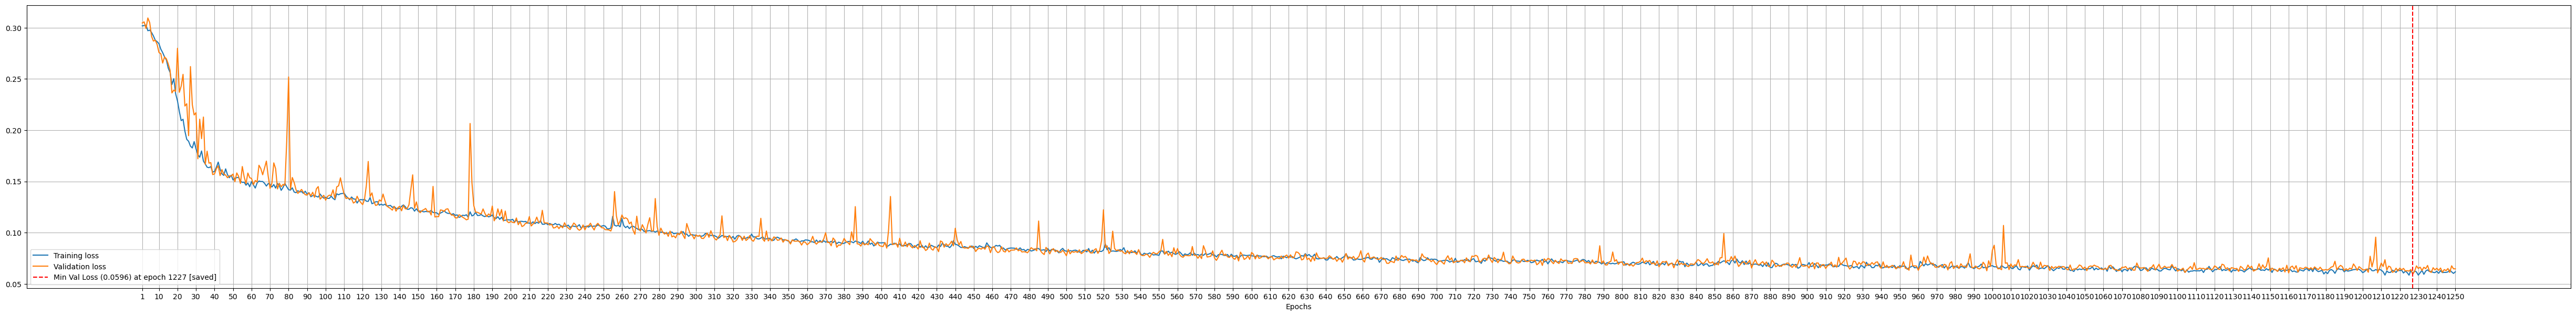

In [17]:
epochs_trained = len(history['train_loss'])
fig = plt.figure(figsize=(max(10, 0.05 * epochs_trained), 7))
plt.plot(np.arange(1, epochs_trained+1), history['train_loss'], label='Training loss')
plt.plot(np.arange(1, epochs_trained+1), history['val_loss'], label='Validation loss')

min_val_loss = min(history['val_loss'])
min_val_loss_epoch = history['val_loss'].index(min_val_loss) +1
plt.axvline(x=min_val_loss_epoch, color='red', linestyle='--', label=f'Min Val Loss ({min_val_loss:.4f}) at epoch {min_val_loss_epoch} [saved]')

interval=10
ticks = [1] + list(range(interval, epochs_trained + 1, interval))   #start in 1, go 1, 10, 20, 30...
plt.xticks(ticks)
#fig.autofmt_xdate()

plt.xlabel("Epochs")
plt.grid(True)
plt.legend()
plt.show()

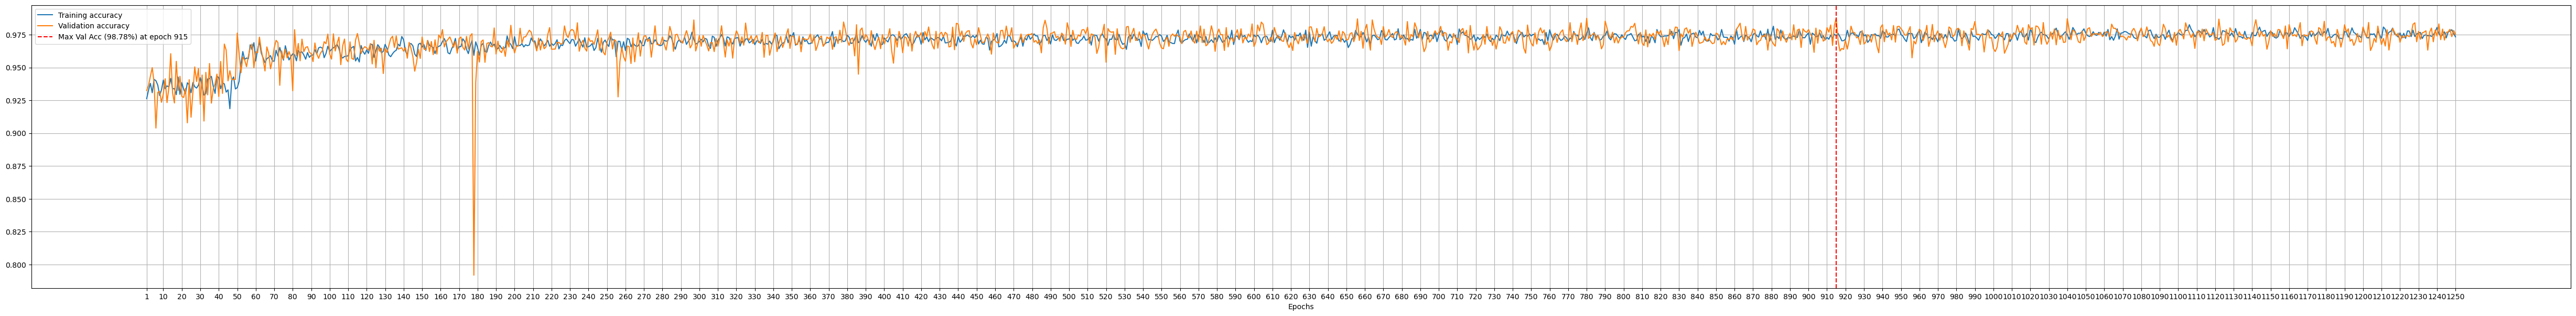

In [18]:
# from tensor to numpy
train_accuracy_cpu = [acc.cpu().numpy()/100 for acc in history['train_accuracy']]
val_accuracy_cpu = [acc.cpu().numpy()/100 for acc in history['val_accuracy']]
#print(train_accuracy_cpu)

fig = plt.figure(figsize=(max(10, 0.05 * epochs_trained), 7))
plt.plot(np.arange(1,epochs_trained+1), train_accuracy_cpu, label='Training accuracy')
plt.plot(np.arange(1,epochs_trained+1), val_accuracy_cpu, label='Validation accuracy')

max_val_acc = max(history['val_accuracy'])
max_val_acc_epoch = history['val_accuracy'].index(max_val_acc) +1
plt.axvline(x=max_val_acc_epoch, color='red', linestyle='--', label=f'Max Val Acc ({max_val_acc:.2f}%) at epoch {max_val_acc_epoch}')

interval=10
ticks = [1] + list(range(interval, epochs_trained + 1, interval))   #start in 1, go 1, 10, 20, 30...
plt.xticks(ticks)

#fig.autofmt_xdate()
plt.xlabel("Epochs")
plt.grid()
plt.legend()
plt.show()

**TEST**

In [19]:
# create model and load saved state 
# #model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)
# load_model_path = './trained_models/20250126_214831_UNet_0.06924
# model.load_state_dict(torch.load(load_model_path))
model.to(device)
model.eval()     # !!! set the dropout and batch normalization layers to evaluation mode

ViGUNet(
  (inp): InputBlock(
    (conv): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): EncoderBlock(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128

In [26]:
test_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # evaluation at native resolution
    # v2.RandomRotation(degrees=(-180, 180)),
    # v2.RandomHorizontalFlip(),
    # v2.RandomVerticalFlip(),
    # v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    # v2.GaussianNoise(),
    # v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 1)),
    #transforms.ToTensor(),    # already tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

# load test images
test_img_dir = './data/CHASE/test/images'
test_gt_dir = './data/CHASE/test/2nd_manual'

test_dataset = Dataset(test_img_dir, test_gt_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [27]:
#check test image
for img, gt, img_name in test_loader:
    print(f"Shape of image: {img.shape}")
    print(f"Shape of GT: {gt.shape}")
    print(f"Name of image: {img_name[0]}") 
    break  # just one

Shape of image: torch.Size([1, 3, 512, 512])
Shape of GT: torch.Size([1, 1, 512, 512])
Name of image: 01_test.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


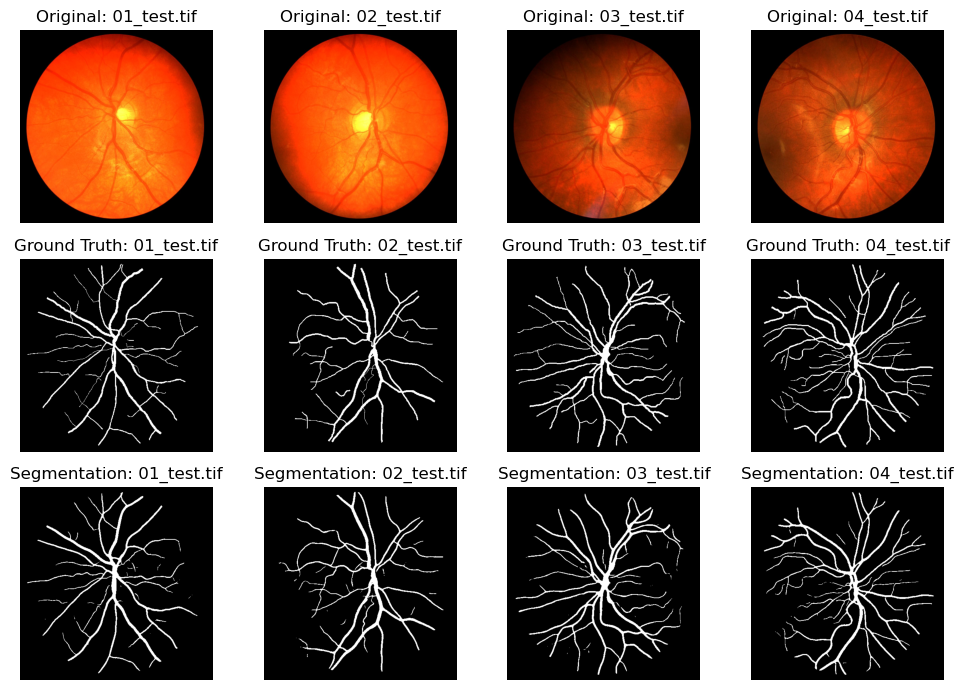

In [28]:
model.eval()   # done before, but just in case...

num_images = 4  # number of images to show
fig, axes = plt.subplots(3, num_images, figsize=(10, 7))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, gt, image_name in test_loader:
        if i >= num_images: 
            break

        # move to cuda
        image = image.to(device)

        output = model(image)  # predict
        output_binary = (output > 0.5).float()  # convert to 0 or 1

        # convert output to image
        output_img = output_binary.squeeze().cpu().numpy()  # delete batch dimension
        gt_img = gt.squeeze().cpu().numpy()

        # original test images
        axes[0, i].imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))  # from tensor to image
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original: {image_name[0]}")
        
        # test images ground truth segmentations
        axes[1, i].imshow(gt_img, cmap='gray')  # grayscale
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Ground Truth: {image_name[0]}")

        # test images predicted segmentations
        axes[2, i].imshow(output_img, cmap='gray')  # grayscale
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Segmentation: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

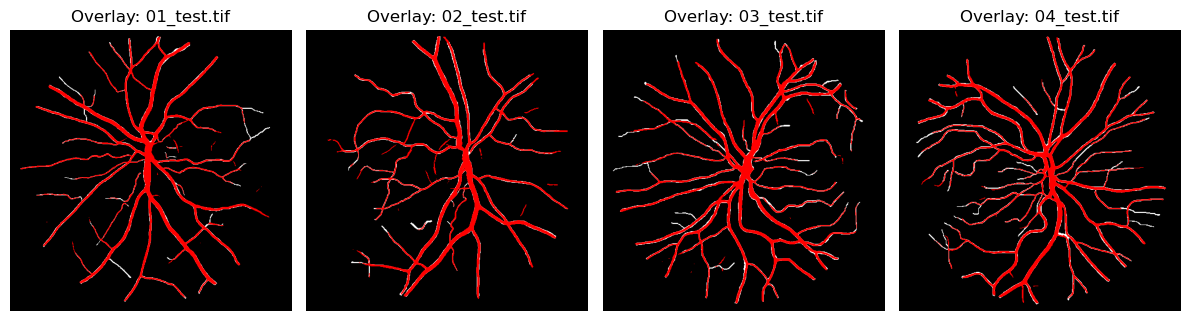

In [29]:
model.eval()   # done before, but just in case...

num_images = 4   # number of images to show
fig, axes = plt.subplots(1, num_images, figsize=(12, 8))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, gt, image_name in test_loader:
        if i >= num_images: 
            break

        # move to CUDA
        image = image.to(device)

        output = model(image)  # predict
        output_binary = (output > 0.5).float()  # binarize prediction

        # convert prediction to image
        output_img = output_binary.squeeze().cpu().numpy()  # delete batch dimension
        gt_img = gt.squeeze().cpu().numpy()  # gt as image

        # Mostrar ground truth como fondo en escala de grises
        axes[i].imshow(gt_img, cmap='gray')  # Fondo: ground truth
        
        # Crear imagen RGBA para superponer
        overlay = np.zeros((*output_img.shape, 4))  # Crear un mapa RGBA
        overlay[..., 0] = 1  # Canal rojo
        overlay[..., 3] = output_img  # Canal alfa (0 para transparente, 1 para opaco)
        
        axes[i].imshow(overlay)  # Superposición en RGBA
        
        axes[i].axis('off')
        axes[i].set_title(f"Overlay: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

**ROC, AUC, Test Accuracy, Dice score, MCC, ccDice**


Dice score: 0.8277

MCC: 0.8158

ccDice score: 0.1566

Test Accuracy: 0.9757

F1 Score: 0.8275




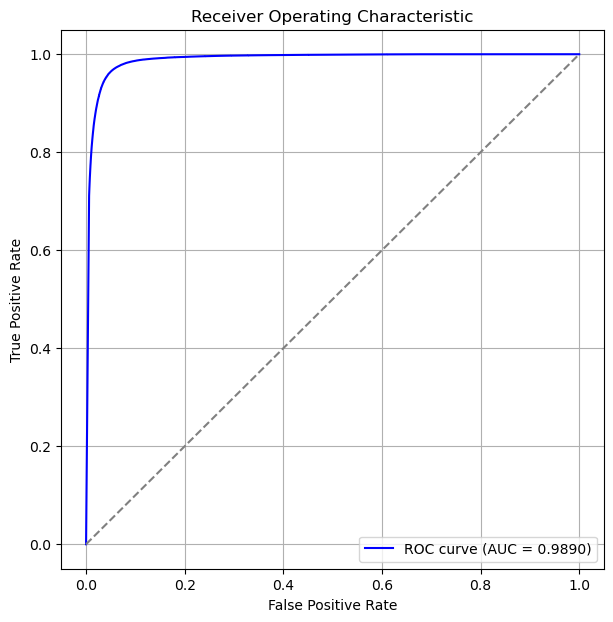

In [30]:
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from utils.dice_score import dice_score                     # custom function to calculate dice score
from utils.matthews_corr_coef import matthews_corr_coef     # custom function to calculate MCC
from utils.ccDice_score import ccDice                       # modified ccDice score (only binary labels)
from skimage.measure import label                           # necessary for ccDice

calculate_ccdice = True    # yes or no. Forced to use CPU: it takes long to compute (5 minutes just 8 images)

all_labels = []       # to store ground truth values for each pixel of each image
all_preds = []        # to store predicted values for each pixel of each image

dice_score_batches = []       # to store Dice score of each batch
mcc_batches = []              # to store MCC of each batch
if calculate_ccdice==True:
    ccdice_score_batches = []     # to store ccDice score of each batch

with torch.no_grad():  # no gradients needed
    for inputs, ground_truth, _ in test_loader:        # for each batch in test loader
        inputs = inputs.to(device)
        ground_truth = ground_truth.to(device)

        outputs = model(inputs)     # predict

        all_labels.append(ground_truth.cpu().numpy())       # real labels for each pixel (0 or 1) 
        all_preds.append(outputs.cpu().numpy())             # probabilities to belong to class 1, given by model
        
        dice = dice_score(outputs, ground_truth, threshold=0.5)
        dice_score_batches.append(dice.item())
        
        mcc = matthews_corr_coef(outputs, ground_truth, threshold=0.5)
        mcc_batches.append(mcc)

        if calculate_ccdice==True:
            y_pred_label, cc_pred = label(((outputs > 0.5).float()).cpu().numpy().squeeze(0), return_num=True)
            y_true_label, cc_true = label(ground_truth.cpu().numpy().squeeze(0), return_num=True)
            ccdice = ccDice(y_pred_label, cc_pred, y_true_label, cc_true, alpha=0.1)    # alpha is level of exigency to join 2 cc (low is permissive, 1.0 is max exigency)
            ccdice_score_batches.append(ccdice)

# compute mean dice score and print
mean_dice_score = torch.tensor(dice_score_batches).mean()
print(f"\nDice score: {mean_dice_score:.4f}")

# compute mean MCC and print
mean_mcc = torch.tensor(mcc_batches).mean()
print(f"\nMCC: {mean_mcc:.4f}")

# compute mean ccDice score and print
if calculate_ccdice==True:
    mean_ccdice_score = torch.tensor(ccdice_score_batches).mean()
    print(f"\nccDice score: {mean_ccdice_score:.4f}")

# list to numpy array
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

# compute mean test accuracy and print
accuracy_sklearn = accuracy_score(list(map(bool,all_labels.flatten())), (all_preds.flatten() > 0.5))
print(f"\nTest Accuracy: {accuracy_sklearn:.4f}")

# compute mean F1 score accuracy and print
f1_sklearn = f1_score(list(map(bool,all_labels.flatten())), (all_preds.flatten() > 0.5))
print(f"\nF1 Score: {f1_sklearn:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(list(map(bool,all_labels.flatten())), all_preds.flatten())     # force labels to binary list (if not, error when transform.resize)

# AUC
roc_auc = auc(fpr, tpr)

# plot ROC
print("\n")
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

trained_models\20250205_182055_ViGUNet_0.05962

In [31]:
# just to visualize the model architecture

'''from torch.utils.tensorboard import SummaryWriter
import torchvision

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/UNet')

# get some random training images
dataiter = iter(train_loader)
images, labels, _ = next(dataiter)

print(images.shape)
images = images.to(device)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

#img_grid = img_grid.unsqueeze(0) 

# write to tensorboard
writer.add_image('train_img', img_grid)

writer.add_graph(model, images)
writer.close()

# write in terminal --->   tensorboard --logdir=runs/Unet'''

'from torch.utils.tensorboard import SummaryWriter\nimport torchvision\n\n# default `log_dir` is "runs" - we\'ll be more specific here\nwriter = SummaryWriter(\'runs/UNet\')\n\n# get some random training images\ndataiter = iter(train_loader)\nimages, labels, _ = next(dataiter)\n\nprint(images.shape)\nimages = images.to(device)\n\n# create grid of images\nimg_grid = torchvision.utils.make_grid(images)\n\n#img_grid = img_grid.unsqueeze(0) \n\n# write to tensorboard\nwriter.add_image(\'train_img\', img_grid)\n\nwriter.add_graph(model, images)\nwriter.close()\n\n# write in terminal --->   tensorboard --logdir=runs/Unet'